# Прогнозирование вероятности оттока клиентов

# Оглавление   
[1 Описание проекта](#description)   
- [1.1 Описание данных](#data)    

[2 Загрузка и изучение данных](#downloading)    
- [2.1  Выводы по разделу](#conclusion1)

[3  Исследовательский анализ](#eda)    
- [3.1  Общий анализ](#eda_all)
- [3.2  Аномальные значения](#abnormal)
- [3.3  Анализ по оттоку](#eda_churn)    
- [3.4  Корреляция признаков](#correlation)    
- [3.5  Выводы по разделу](#conclusion2)

[4  Модель прогнозирования оттока](#predict)    
- [4.1  Выводы по разделу](#conclusion3)

[5  Кластеризация клиентов](#cluster)   
- [5.1  Выводы по разделу](#conclusion4)

[6  Результаты исследования](#result)    

### Описание проекта <a id='description'></a>
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
Сеть столкнулась с распространённой проблемой фитнес-клубов и других сервисов — оттоком клиентов. Для фитнес-центра будем считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.  
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» предоставил данные клиентских анкет и поставил задачу — провести анализ и подготовить план действий по удержанию клиентов.  
В ходе исследования нам предстоит:    
- Спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;    

По результатам исследования необходимо сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
- выделить целевые группы клиентов;
- предложить меры по снижению оттока;
- определить другие особенности взаимодействия с клиентами.

#### Описание данных <a id='data'></a>

Таблица `gym_churn.csv` содержит данные на месяц до оттока и факт оттока на определённый месяц. Таблица состоящит из следующих полей:    
Данные клиента за предыдущий до проверки факта оттока месяц:    

- `gender` — пол;    
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;    
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);    
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);    
- `Phone` — наличие контактного телефона;    
- `Age` — возраст;    
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).    

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);    
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);    
- `Group_visits` — факт посещения групповых занятий;    
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;    
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;    
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.    
- `Churn` — факт оттока в текущем месяце.    

### Загрузка и изучение данных <a id='downloading'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
import scipy.stats as st
from scipy.cluster.hierarchy import dendrogram, linkage

warnings.filterwarnings('ignore')

Загрузим таблицу `gym_churn.csv` с параметрами пользователей и показателем оттока.

In [2]:
try:
    data = pd.read_csv('/datasets/gym_churn.csv', sep=',')
except:
    data = pd.read_csv('gym_churn.csv', sep=',')
    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Таблица загрузилась без ошибок, приведём названия столбцов к "змеиному" регистру и посмотрим информацию о выборке

In [3]:
data.columns = [x.lower().replace(' ', '_') for x in data.columns.values]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Данные в столбце `month_to_end_contract` относятся к типу 'float64', проверим, возможно в данном поле содержатся только целые значения и формат с плавающей точкой избыточен

In [4]:
data['month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

В столбце `month_to_end_contract` содержатся только целые значения количества месяцев до конца контракта, приведём данные в нём к типу 'int64'

In [5]:
data['month_to_end_contract'] = data['month_to_end_contract'].astype('int64')
data['month_to_end_contract'].dtypes

dtype('int64')

В таблице 4000 записей с данными пользователей, типы данных в столбцах соответствуют содержащейся информации.
Проверим наличие дубликатов в данных

In [6]:
data.duplicated().sum()

0

Дубликаты отсутствуют.

Проверим наличие пропусков

In [7]:
data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропуски также отсутствуют

#### Вывод: <a id='conclusion1'></a>

Загрузка данных прошла без ошибок. Таблица содержит 4000 записей о клиентах сети фитнес-центров, данные состоят из 13 полей с признаками и целевым полем с фактором оттока. Данные в столбце `month_to_end_contract` приведены к типу 'int64', теперь все типы данных в таблице соответствуют содержащейся в столбцах информации, дубликаты и пропуски отсутствуют. Названия столбцов преведены к змеиному регистру. Выборка является достаточной для проведения исследования, данные готовы для дальнейшего анализа.

### Исследовательский анализ <a id='eda'></a>

#### Общий анализ <a id='eda_all'></a>    

Посмотрим на общую картину распределения значений в данных

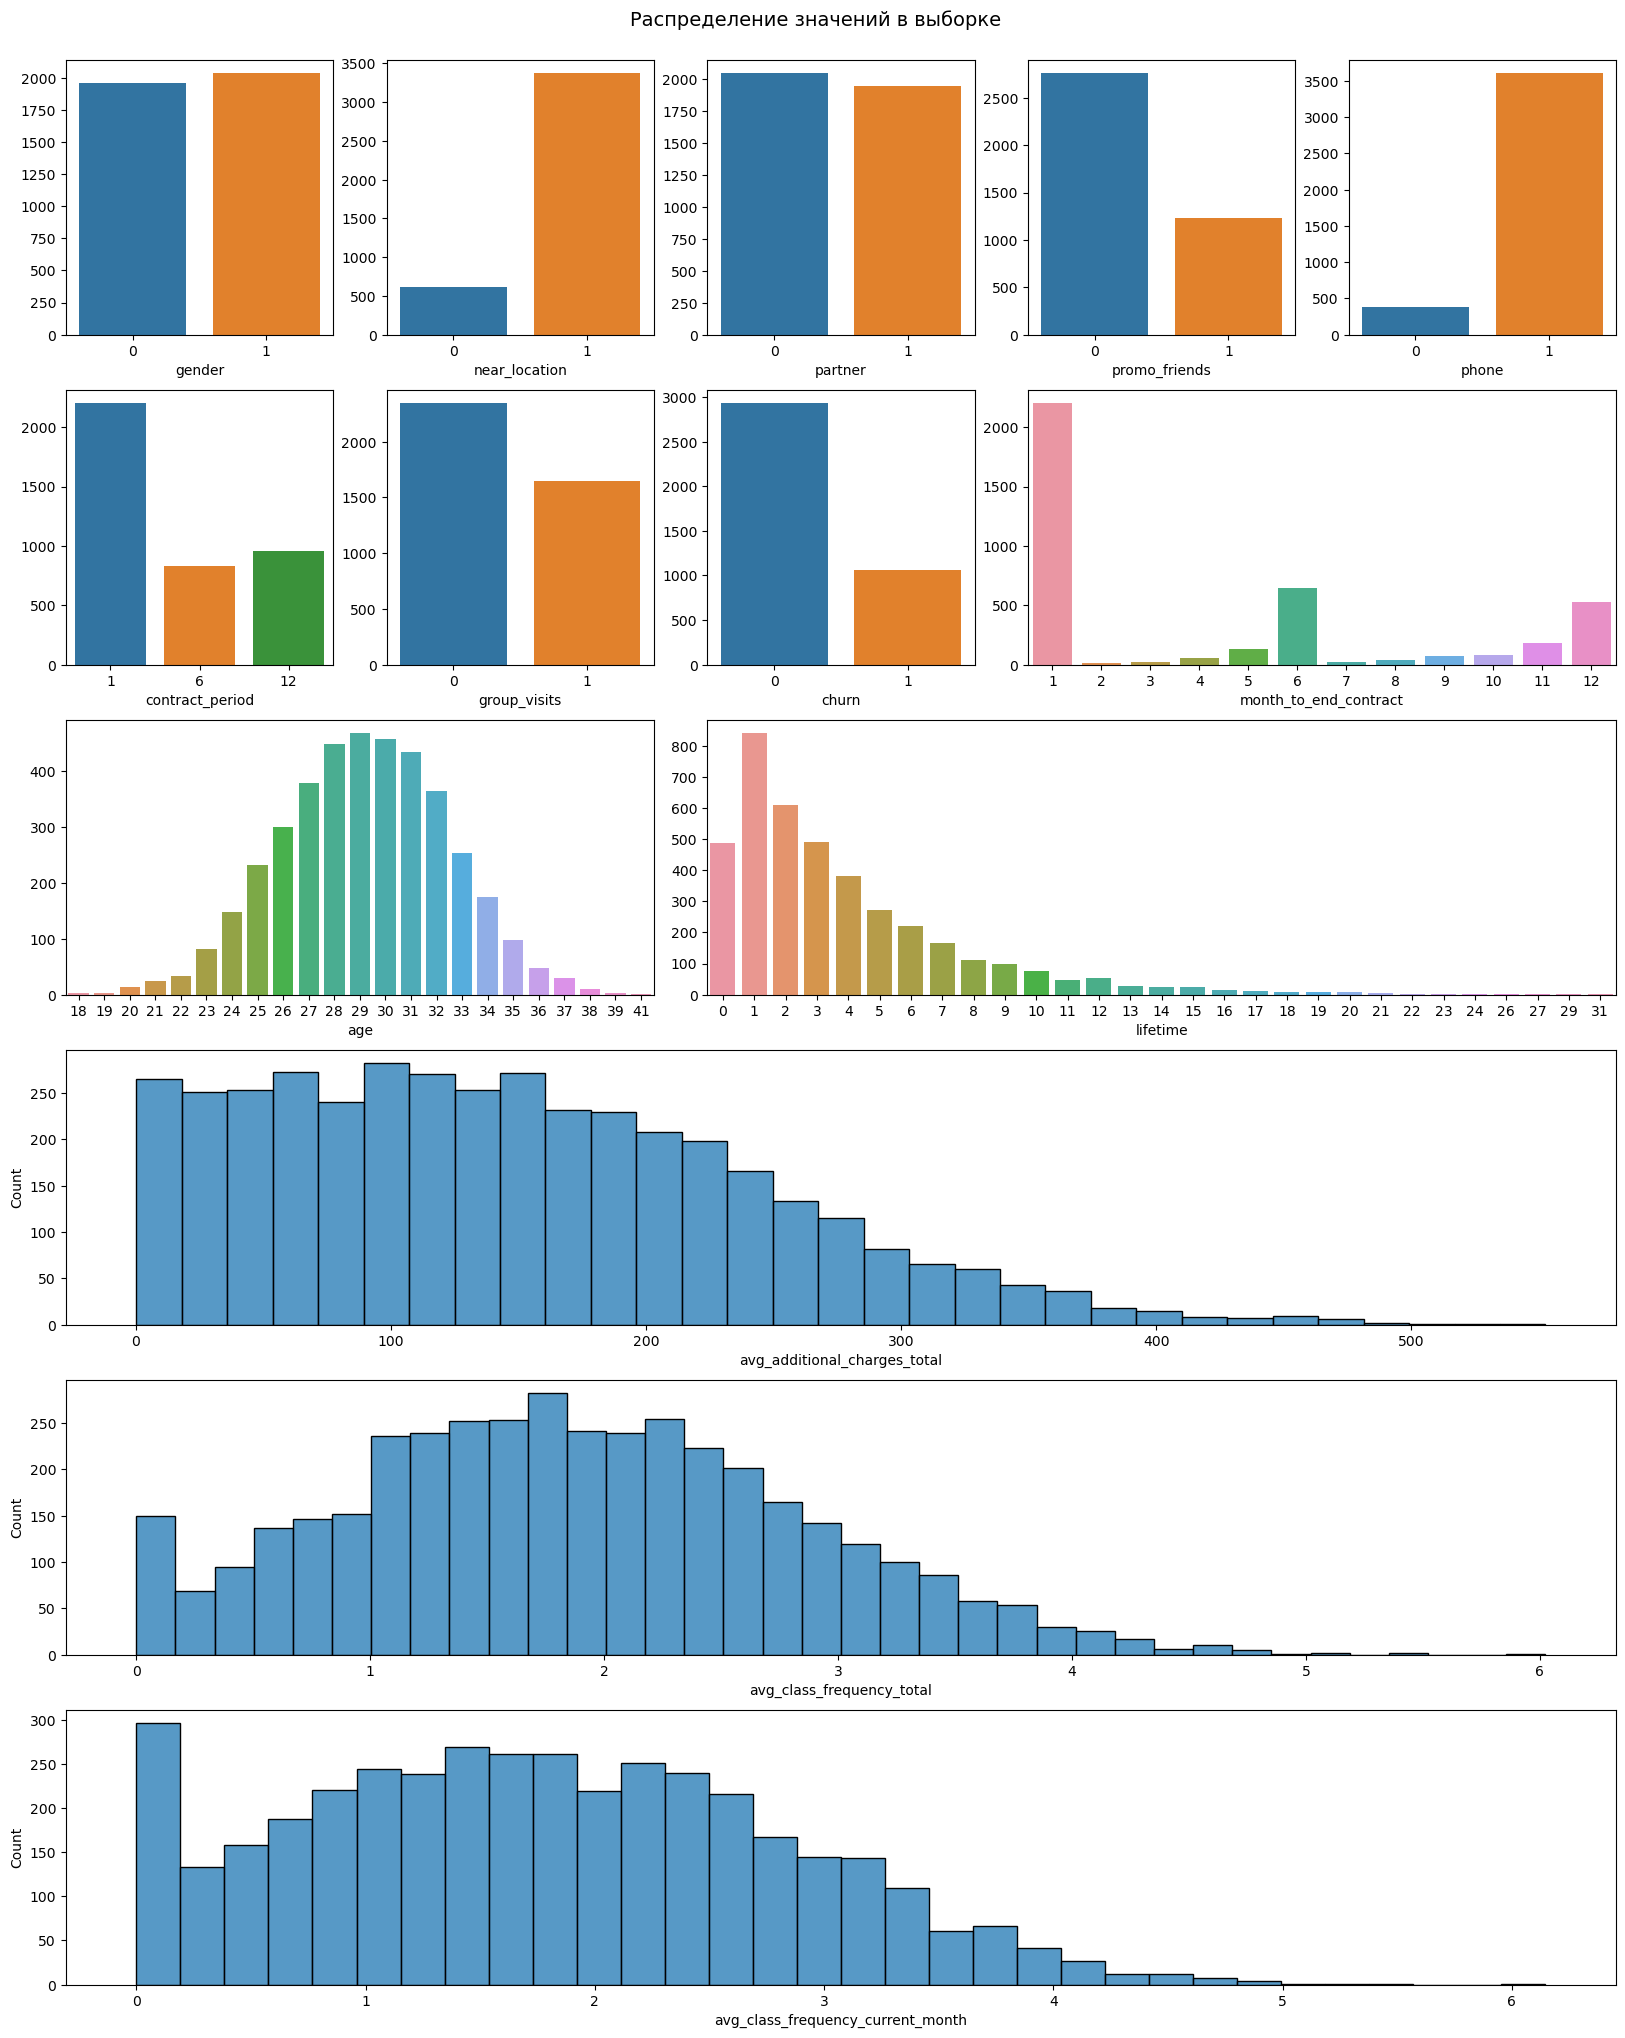

In [8]:
def draw_count(col_name, pos):    
    sns.countplot(data=data, x=col_name, ax=plt.subplot(6,5,pos))
    plt.xlabel(column)
    plt.ylabel(None)

fig = plt.figure(figsize=(20, 25))
position = [(16,20), (21,25), (26,30), (9,10), (11,12), (13,15)]
i=1
for column in data.select_dtypes(include=['int64']).columns:
    if column=='lifetime':
        draw_count(column, position[5])
    elif column=='month_to_end_contract':
        draw_count(column, position[3])
    elif column=='age':
        draw_count(column, position[4])
    else:
        draw_count(column, i)
        i+=1

p = 0
for column in data.select_dtypes(include=['float64']).columns:
    sns.histplot(data=data, x=column, ax=plt.subplot(6,5,position[p]))
    p+=1
        
fig.suptitle('Распределение значений в выборке', y=0.9, fontsize = 14)
plt.show()

Значительные выбросы в данных отсутствуют, но распределения в столбцах `avg_additional_charges_total`, `lifetime`, `avg_class_frequency_total` и `avg_class_frequency_current_month` выглядят подозрительно, далее мы проверим их на наличие аномальных значений. Распределения в некоторых столбцах близки к нормальным, посмотрим, сохранится ли картина после работы с аномальными значениями. В данных прослеживается несколько категории - поля с непрерывными значениями, дискретными значениями и бинарными значениями, показывающими наличие или отсутствие принадлежности к признаку. Зададим списки с обозначенными категориями и посмотрим подробнее на распределения дискретных и непрерывных величин

In [9]:
numeric_columns = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
                     'avg_class_frequency_total', 'avg_class_frequency_current_month', 'contract_period']
boolean_columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']
data[numeric_columns].describe().round(2)

,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,contract_period
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,29.18,146.94,4.32,3.72,1.88,1.77,4.68
std,3.26,96.36,4.19,3.75,0.97,1.05,4.55
min,18.00,0.15,1.00,0.00,0.00,0.00,1.00
25%,27.00,68.87,1.00,1.00,1.18,0.96,1.00
50%,29.00,136.22,1.00,3.00,1.83,1.72,1.00
75%,31.00,210.95,6.00,5.00,2.54,2.51,6.00
max,41.00,552.59,12.00,31.00,6.02,6.15,12.00


Средняя длительность абонемента - 4,5 месяца, медианная - 1 месяц, максимальная - 1 год, стандартное отклонение - более 4 месяцев. Средний и медианный возраст клиента - 29 лет, максимальный - 41 год, минимальный - 18 лет. Стандартное отклонение - чуть более 3-х лет. Средняя выручка дополнительных услуг на одного клиента - 146, медианная - 136, максимальная - 552, стандартное отклонение - 96.3. Средний срок до окончания абонемента на момент опроса - чуть более 4 месяцев, минимальный и медианный - 1 месяц, максимальный - 12 месяцев, стандартное отклонение - более 4 месяцев. Среднее время с момента первого посещения почти 4 месяца, медианное - 3 месяца, минимальное - 0 месяцев, это новые клиенты. Наибольшее время с момента первого посещения составляет 31 месяц, стандартное отклонение - почти 4 месяца. В текущем месяце средняя частота посещений - 1.7 раза в неделю, медианная - тоже 1.7 раза в неделю, минимальная - 0, максимальная - 6 раз. Общее среднее число посещений в неделю - 1.8, медианное также 1.8. В остальном схоже с показателями текущего месяца.

Далее рассмотрим как распределены бинарные значения

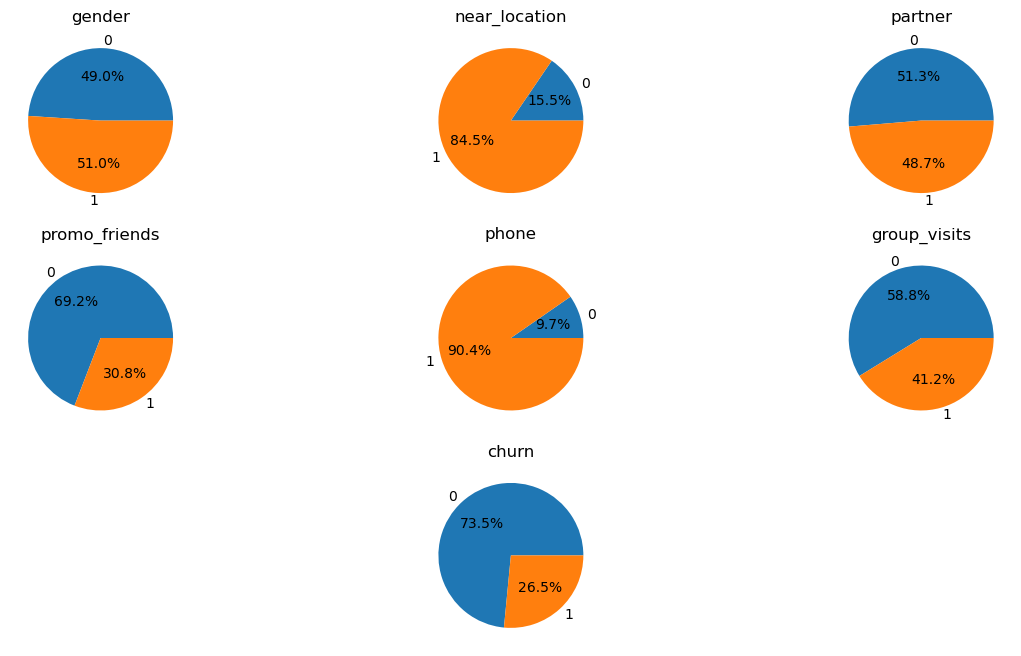

In [10]:
def draw_pie(col_name, pos):
    pie_series = pd.Series([(1- data[col_name].mean()), (data[col_name].mean())])
    pie_series.plot(kind='pie', grid=True, ax=pos, autopct='%.1f%%', title=col_name)
    plt.xticks(rotation=0, ha='center')

plt.figure(figsize=(15, 8))
ax = []
for i in range(6):
    ax.append(i+1)
    ax[i] = plt.subplot(3, 3, i+1)
    draw_pie(boolean_columns[i], ax[i])
    
ax8 = plt.subplot(3, 3, 8)
draw_pie('churn', ax8)
plt.show()

Клиенты распредилены по полу практически поровну - 49% и 51%, 84% клиентов живут или работают поблизости от фитнес-центров сети. Почти 49% клиентов посещают фитнес-центр по партнёрской программе, 30% клиентов пришли по рекомендации друзей, 90% клиентов указали в анкете свой телефон, 41% клиентов посещали групповые занятия. Отток клиентов в текущем месяце составил 26.5%

#### Аномальные значения <a id='abnormal'></a>  

Ранее, на этапе общего обзора данных, распределения значений в полях `avg_additional_charges_total`, `lifetime`, `avg_class_frequency_total` и `avg_class_frequency_current_month` показались подозрительными, перед дальнейшим исследованием проверим их на наличие аномальных значений

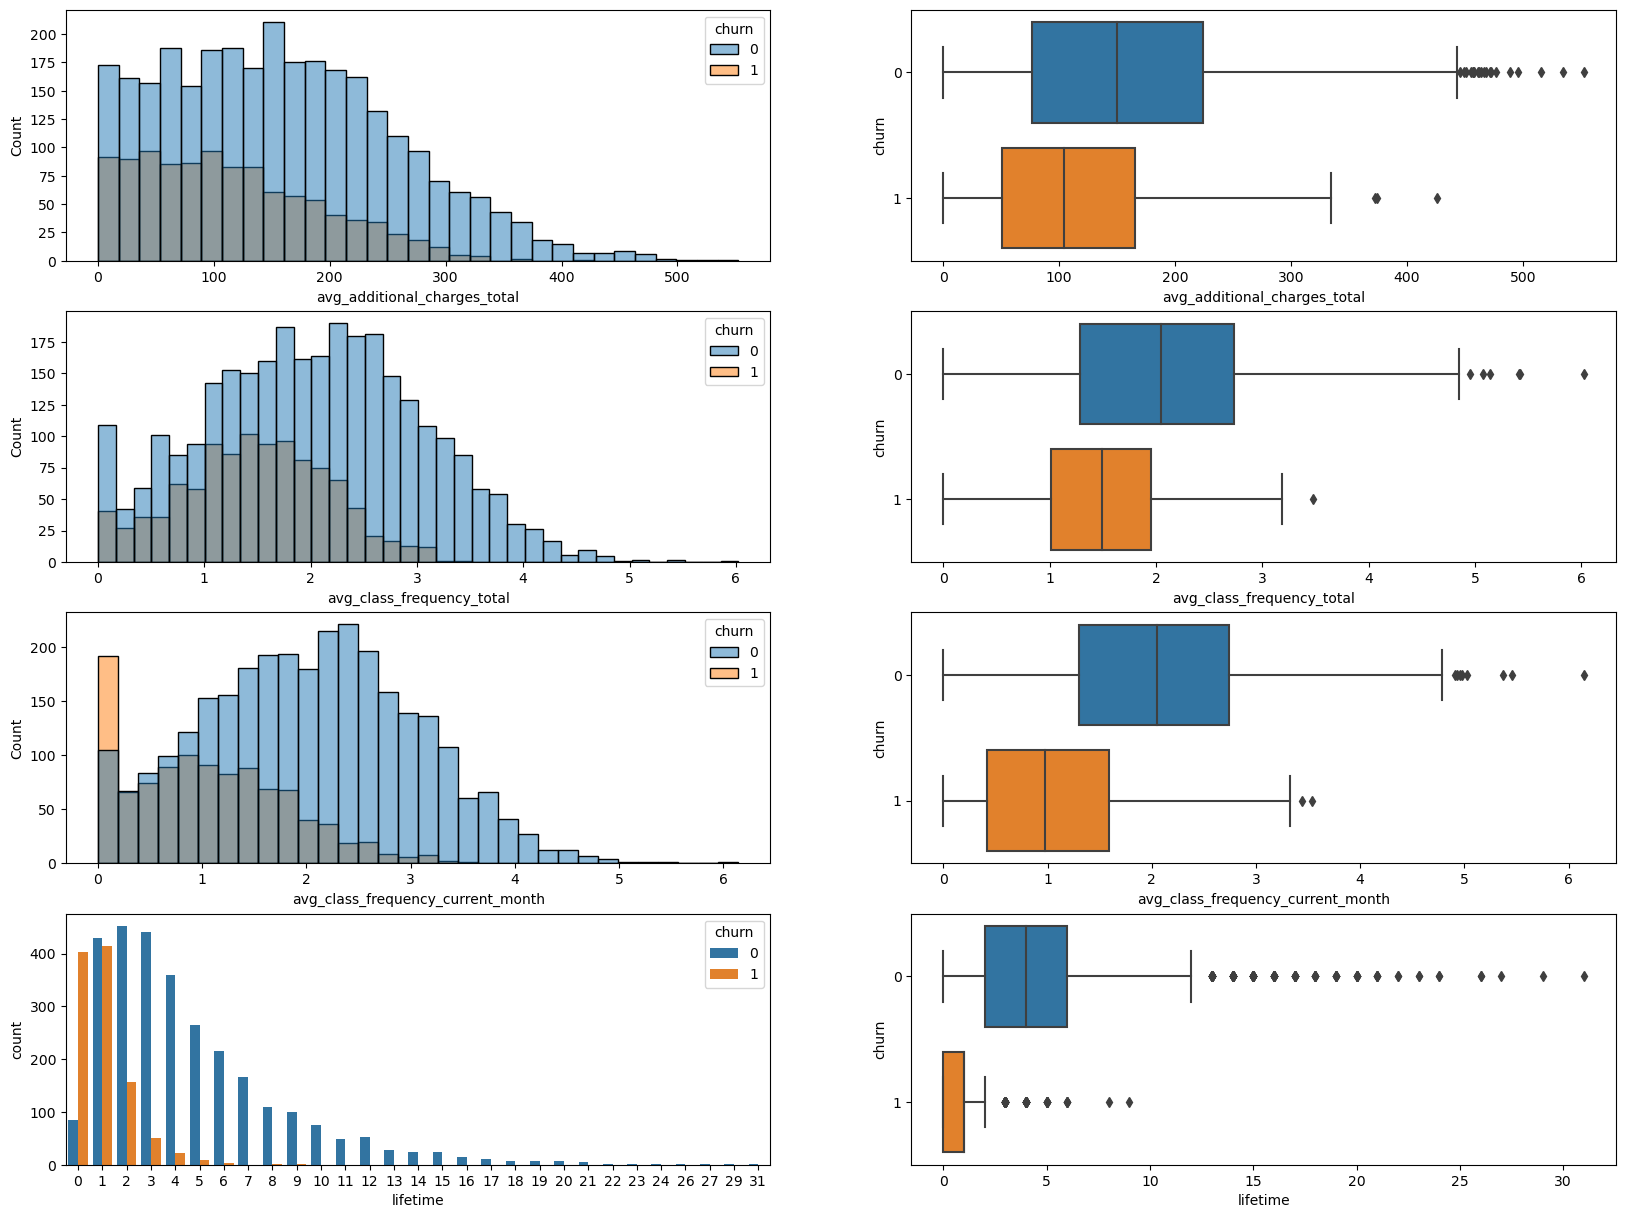

In [11]:
suspect_columns = ['avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
plt.figure(figsize=(20, 15))
i=1
for column in suspect_columns:
    if column=='lifetime':
        sns.countplot(data=data, x=column, hue='churn',
                      ax=plt.subplot(len(suspect_columns),2,(len(suspect_columns)*2 - 1)))
        sns.boxplot(data=data, x=column, y='churn', orient='h',
                    ax=plt.subplot(len(suspect_columns),2,(len(suspect_columns)*2 )))
    else:
        sns.histplot(data=data, x=column, hue='churn', ax=plt.subplot(len(suspect_columns),2,i))
        sns.boxplot(data=data, x=column, y='churn', orient='h', ax=plt.subplot(len(suspect_columns),2,i+1))
        i+=2
plt.show()

В данных присутствуют одиночные выбросы, которые могут привести к переобучению модели на крайних значениях, чтобы избежать этого удалим аномальные значения больше 99 квантиля. Сначала посмотрим какие это значения для параметров

In [12]:
for col_name in suspect_columns:
    print('Для', col_name, '- 99% выборки меньше ', round(data[col_name].quantile(q=0.99), 2))

Для avg_additional_charges_total - 99% выборки меньше  401.0
Для lifetime - 99% выборки меньше  17.0
Для avg_class_frequency_total - 99% выборки меньше  4.2
Для avg_class_frequency_current_month - 99% выборки меньше  4.19


Уберём сильно отклоняющиеся значения в столбцах `avg_class_frequency_current_month`, `lifetime`, `avg_additional_charges_total`, `avg_class_frequency_total` и посмотрим размер оставшейся выборки

In [13]:
clean_data = data.loc[(data['avg_class_frequency_current_month'] < 5) & 
                      (data['lifetime'] < 17) &
                      (data['avg_additional_charges_total'] < 450) &
                      (data['avg_class_frequency_total'] < 5)
                     ].copy()
clean_data.shape

(3929, 14)

Всего было удалено 71 аномальное значение, оставшаяся выборка сохранила репрезентативность

#### Анализ по оттоку <a id='eda_churn'></a>  

Рассмотрим особенности лояльных клиентов и клиентов из оттока, начнём со средних значений

In [14]:
clean_data.groupby('churn').mean().round(3).T

churn,0,1
gender,0.511,0.511
near_location,0.873,0.768
partner,0.537,0.355
promo_friends,0.355,0.184
phone,0.904,0.903
contract_period,5.753,1.729
group_visits,0.460,0.269
age,29.978,26.990
avg_additional_charges_total,156.474,115.083
month_to_end_contract,5.290,1.663


- Ушедшие клиенты в основном с небольшим перидом контракта - 1.7 месяца. Оставшиеся - с более длительным периодом контракта-  5.7 месяцев. Возможно ушедшие брали небольшие длительности контрактов, чтобы оценить свои возможности и качество услуг заведения.
- Средний возраст оставшихся клиентов чуть выше ушедших - примерно 30 и 27 лет, похоже с возрастом люди более стабильно придерживаются своих планов.  
- Если смотреть на траты на допуслуги фитнес-центра, то видим, что среди ушедших средние траты были примерно 115 , а среди оставшихся - 156. Кажется лояльные пользователи выгоднее для фитнес-центра, но если посмотреть на среднее значение параметра количества месяцев до конца контракта, то у лояльных клиентов оно составляет 5.3, а у ушедших в отток 1.6, то есть, клиенты оттока выгодны тем, что платят но не занимают место в зале и на их место можно привлечь новых посетителей. 
- Средний лайфтайм ушедших клиентов - меньше месяца. Возможно чтобы его повысить нужно проработать стратегию удержания новых клиентов. Лояльные клиенты в среднем показывают лайфтайм 4.4 месяца.
- Средняя частота посещений в неделю в текщем месяце у оставшихся в два раза больше чем у ушедших (2 раза в неделю против 1 раза в неделю). Возможно клиентам из оттока сложнее вписать регулярное посещение зала в свой график, за всё время наблюдений картина для них улучшается - соотношение 2 раза в неделю против 1.4, но общая тенденция сохраняется
- Распределение по полу примерно равное как для тех кто ушел, так и для тех, кто остался.   
- 76% клиентов из оттока жили или работали там, где находился фитнес-центр.
- 18% ушедших клиентов первоначально записывались в рамках акции «приведи друга», лояльных по этому параметру - 35%.     
- Наличие контактного телефона тоже не отличатся для обеих групп и составляет 90%. 
- 26% ушедших посещали групповые занятия, среди лояльных клиентов 46% посещали групповые занятия.

Далее посмотрим как распределяются непрерывные и дискретные значения признаков для клиентов из оттока и лояльных клиентов

<Figure size 2000x1600 with 0 Axes>

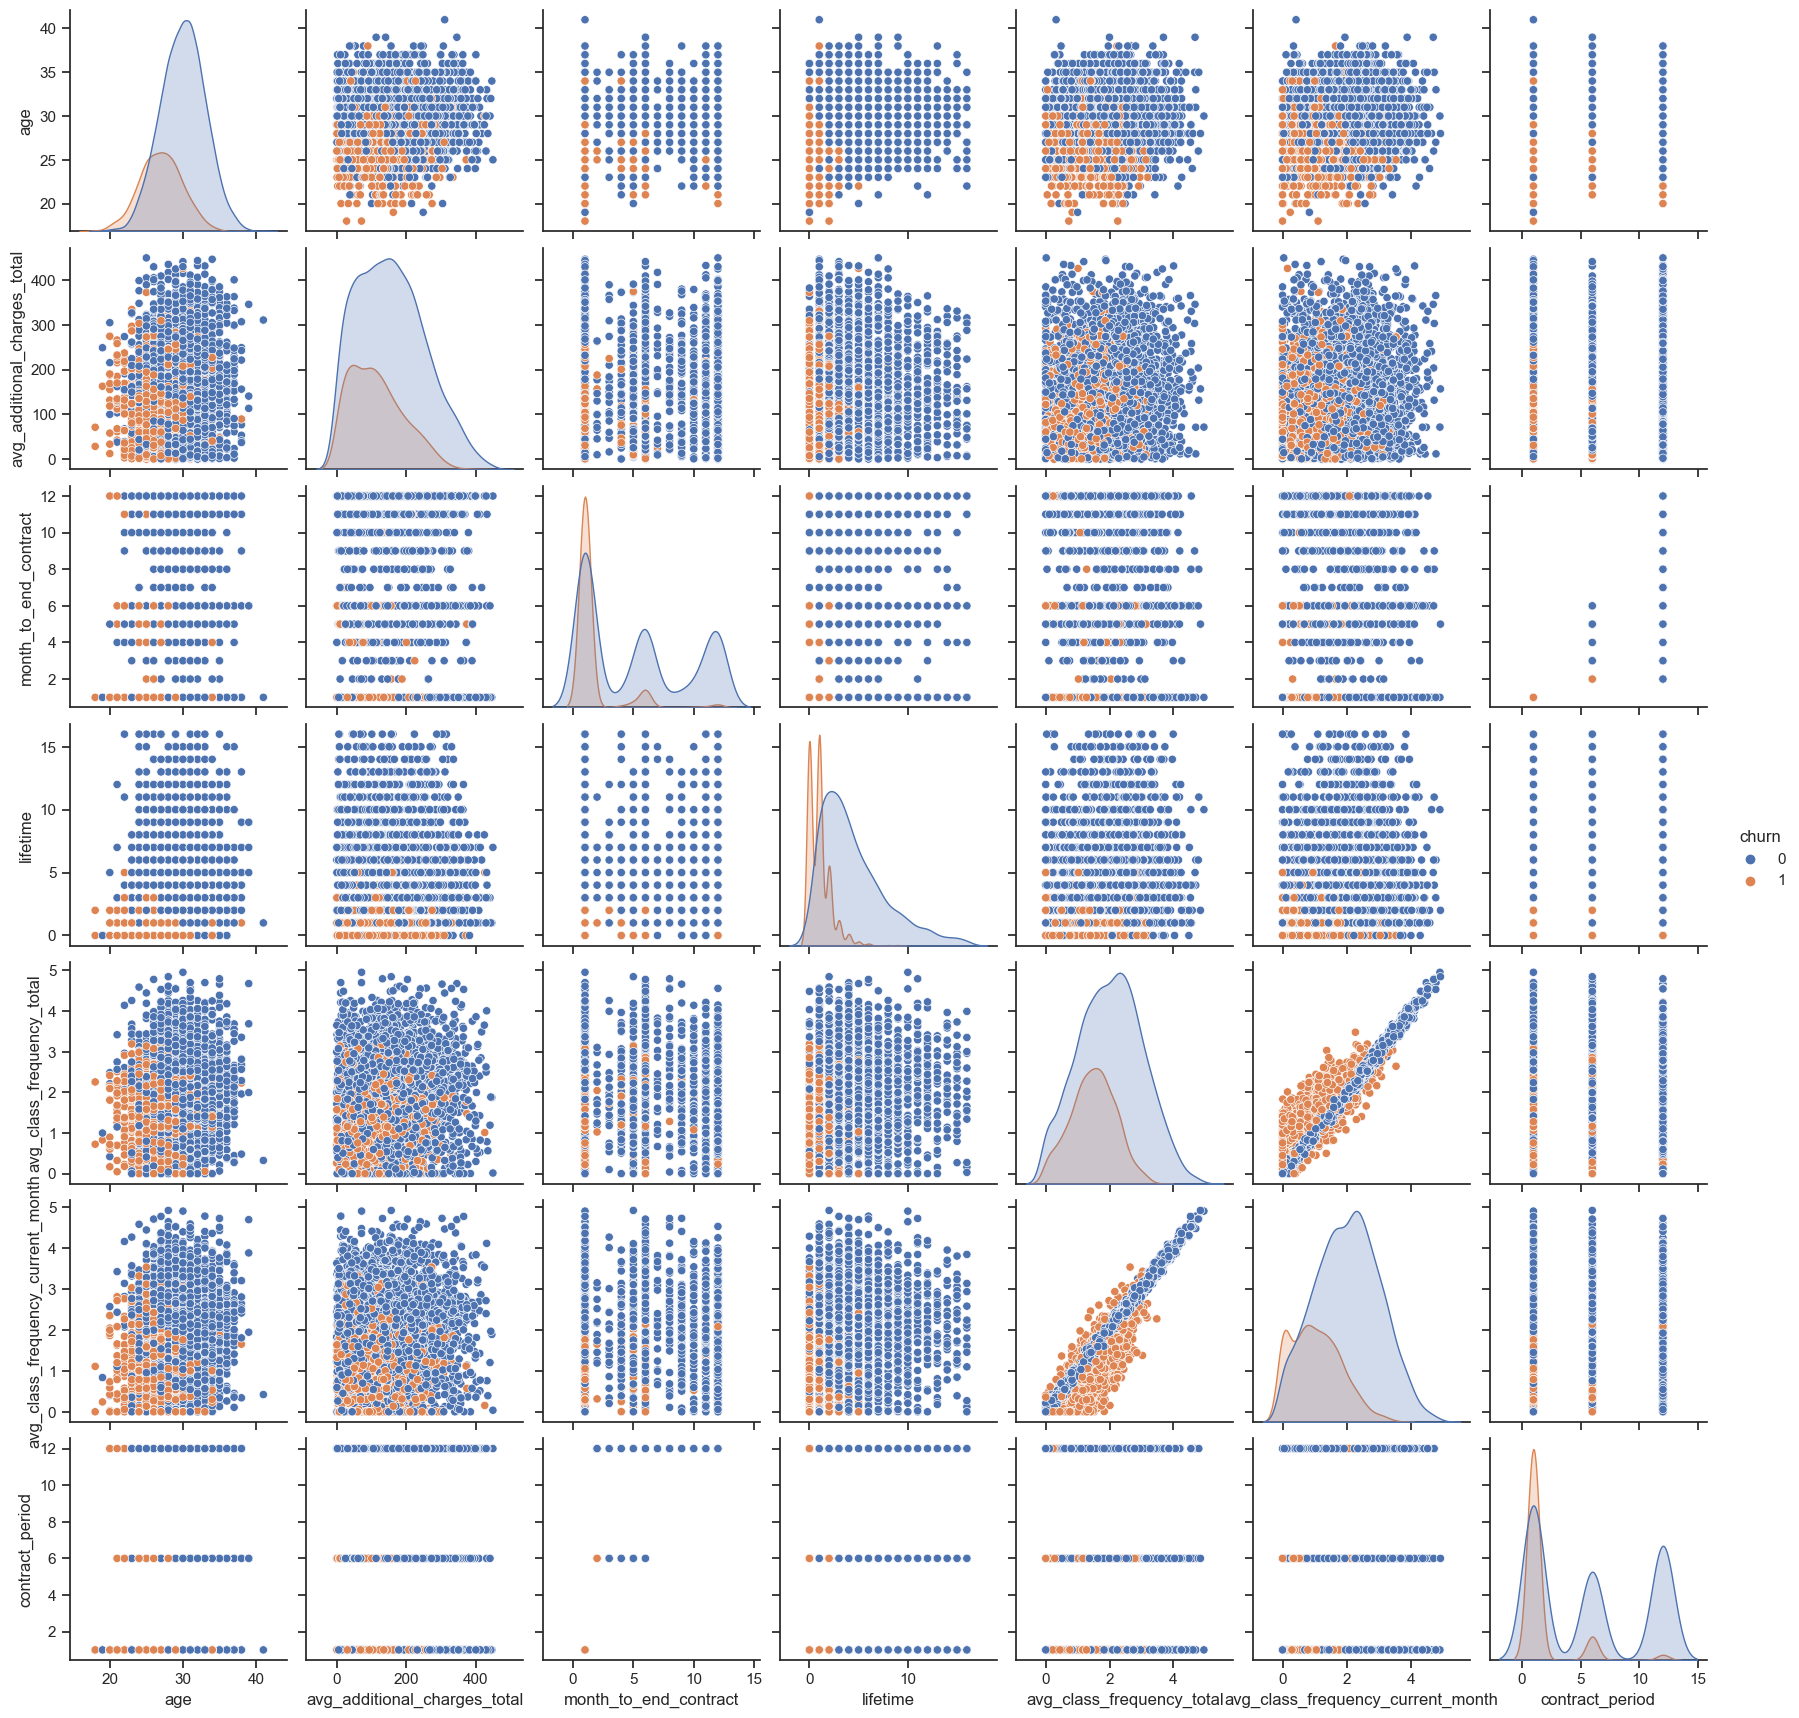

In [15]:
plt.figure(figsize=(20, 16))
sns.set_theme(style="ticks")
pair_list = numeric_columns.append('churn')
sns.pairplot(clean_data[numeric_columns], hue="churn");

Сильная корреляция прослеживается только для полей `avg_class_frequency_total` и `avg_class_frequency_current_month`, в дальнейшем рассмотрим корреляцию подробнее на матрице.

- Распределение длительности действующего абонемента по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего, меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. А для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.   
- По среднему возрасту обе группы имеют нормальное распределение. Как и со средними значениями, график показывает, что чаще лояльные клиенты имеют больший возраст, чем ушедшие.   
- Распределение средней выручки от других услуг фитнес-центра подтверждает вывод по средним значениям, что лояльные клиенты больше тратят на дополнительные услуги в фитнес-центре.   
- Распределение времени с момента первого обращения для ушедших в отток клиентов сильно смещено влево и редко достигает высоких значений, а для лояльных клиентов характерны более высокие значения лайфтайма.   
- Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц.   


Распределение значений в полях `avg_class_frequency_total`, `avg_class_frequency_current_month`, `lifetime`, `avg_additional_charges_total` близко к нормальному и позволяет сделать предположение, что величины этих параметров больше у лояльных пользователей, чем у пользователей из оттока.    

Сформулируем гипотезы и подготовим таблицу для их вывода

In [16]:
# Выбираем параметры и задаём гипотезы
hypotesis_dict = {'avg_class_frequency_total': 
                            ['Частота посещений лояльных клиентов и клиентов из оттока равны',
                            'Частота посещений лояльных клиентов больше частоты посещения клиентов из оттока'],
                'avg_class_frequency_current_month': 
                            ['Частота посещений лояльных клиентов и клиентов из оттока в текущем месяце равны',
                            'Частота посещений лояльных клиентов больше частоты посещения клиентов из оттока в текущем месяце'],
                'lifetime' : 
                            ['Время с момента первого посещения лояльных клиентов и клиентов из оттока равны',
                            'Время с момента первого посещения лояльных клиентов больше чем у клиентов из оттока'],
                'avg_additional_charges_total' : 
                            ['Выручка от доп. услуг у лояльных клиентов и клиентов из оттока равны',
                            'Выручка от доп. услуг у лояльных клиентов больше чем у клиентов из оттока']}
# Формируем датафрейм для хранения результатов проверки гипотез
result_stat = pd.DataFrame(columns=['parameter', 'H0', 'H1', 'p-value', 'result'])
result_stat['parameter'] = [key for key in hypotesis_dict]
result_stat['H0'] = [hypotesis_dict[key][0] for key in hypotesis_dict]
result_stat['H1'] = [hypotesis_dict[key][1] for key in hypotesis_dict]

Проверим гипотезы и внесём результаты в таблицу

In [17]:
for key in hypotesis_dict:
    alpha = 0.05

    # Распределение параметра первой группы пользователей (лояльной)
    first_group_total = clean_data.loc[clean_data['churn'] == 0][key]

    # Распределение параметра второй группы пользователей (из оттока)
    second_group_total = clean_data.loc[clean_data['churn'] == 1][key]

    # проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
    results = st.ttest_ind(first_group_total, second_group_total, alternative='greater')
    result_stat.loc[result_stat['parameter'] == key, 'p-value'] = str(results.pvalue)
    # проверяем p-value
    if results.pvalue < alpha:
        result_stat.loc[result_stat['parameter'] == key, 'result'] = 'Отвергаем нулевую гипотезу'
    else:
        result_stat.loc[result_stat['parameter'] == key, 'result'] = 'Нет оснований отвергнуть нулевую гипотезу'
result_stat

,parameter,H0,H1,p-value,result
0,avg_class_frequency_total,Частота посещений лояльных клиентов и клиентов из оттока равны,Частота посещений лояльных клиентов больше частоты посещения клиентов из оттока,2.8948180380854236e-58,Отвергаем нулевую гипотезу
1,avg_class_frequency_current_month,Частота посещений лояльных клиентов и клиентов из оттока в текущем месяце равны,Частота посещений лояльных клиентов больше частоты посещения клиентов из оттока в текущем месяце,1.2503274782147036e-164,Отвергаем нулевую гипотезу
2,lifetime,Время с момента первого посещения лояльных клиентов и клиентов из оттока равны,Время с момента первого посещения лояльных клиентов больше чем у клиентов из оттока,8.676780305603399e-215,Отвергаем нулевую гипотезу
3,avg_additional_charges_total,Выручка от доп. услуг у лояльных клиентов и клиентов из оттока равны,Выручка от доп. услуг у лояльных клиентов больше чем у клиентов из оттока,1.5175018322227096e-35,Отвергаем нулевую гипотезу


Проверка гипотез подтвердила, что лояльные пользователи чаще посещают фитнес-центр чем ушедшие в отток как в текущем месяце, так и за всё время наблюдений. Лайфтайм и выручка от доп. услуг также выше у лояльных пользователей. 

Далее построим столбчатые графики бинарных признаков для клиентов из оттока и лояльных клиентов

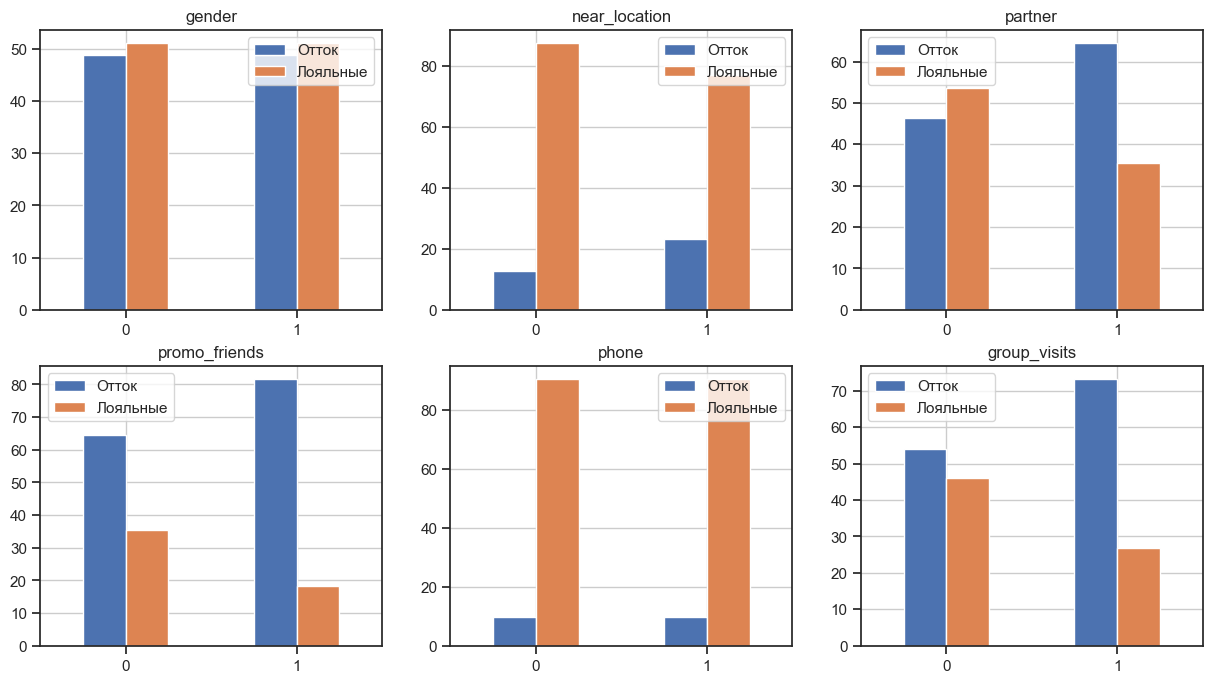

In [18]:
plt.figure(figsize=(15, 8))
ax = []
for i in range(6):
    ax.append(i+1)
    ax[i] = plt.subplot(2, 3, i+1)

    bar_series = pd.DataFrame([[((1- clean_data.loc[clean_data['churn'] == 0][boolean_columns[i]].mean())*100),
                            ((1- clean_data.loc[clean_data['churn'] == 1][boolean_columns[i]].mean())*100)], 
                            [clean_data.loc[clean_data['churn'] == 0][boolean_columns[i]].mean()*100,
                            clean_data.loc[clean_data['churn'] == 1][boolean_columns[i]].mean()*100]])
    bar_series = bar_series.T
    bar_series.columns=['Отток', 'Лояльные']
    bar_series.plot( kind='bar', grid=True, ax=ax[i], title=boolean_columns[i])
    plt.xticks(rotation=0, ha='center')
    
plt.show()

- По полу, близости к фитнес-центру, наличию контактного телефона обе группы имеют схожее равномерное распределение.   
- Есть различия в распределении групп между теми, кто является сотрудником компании-партнёра клуба и не является. Процент клиентов, уходящих в отток выше на 20% среди участников партнёрской программы. 
- Клиенты, посещающие групповые занятия, также на 20% более склонны к оттоку, чем занимающиеся индивидуально.    
- Процент оттока среди участников промо-акции "Приведи друга" клиентов больше на 15%, но распределения схожи.   

#### Корреляция признаков <a id='correlation'></a>

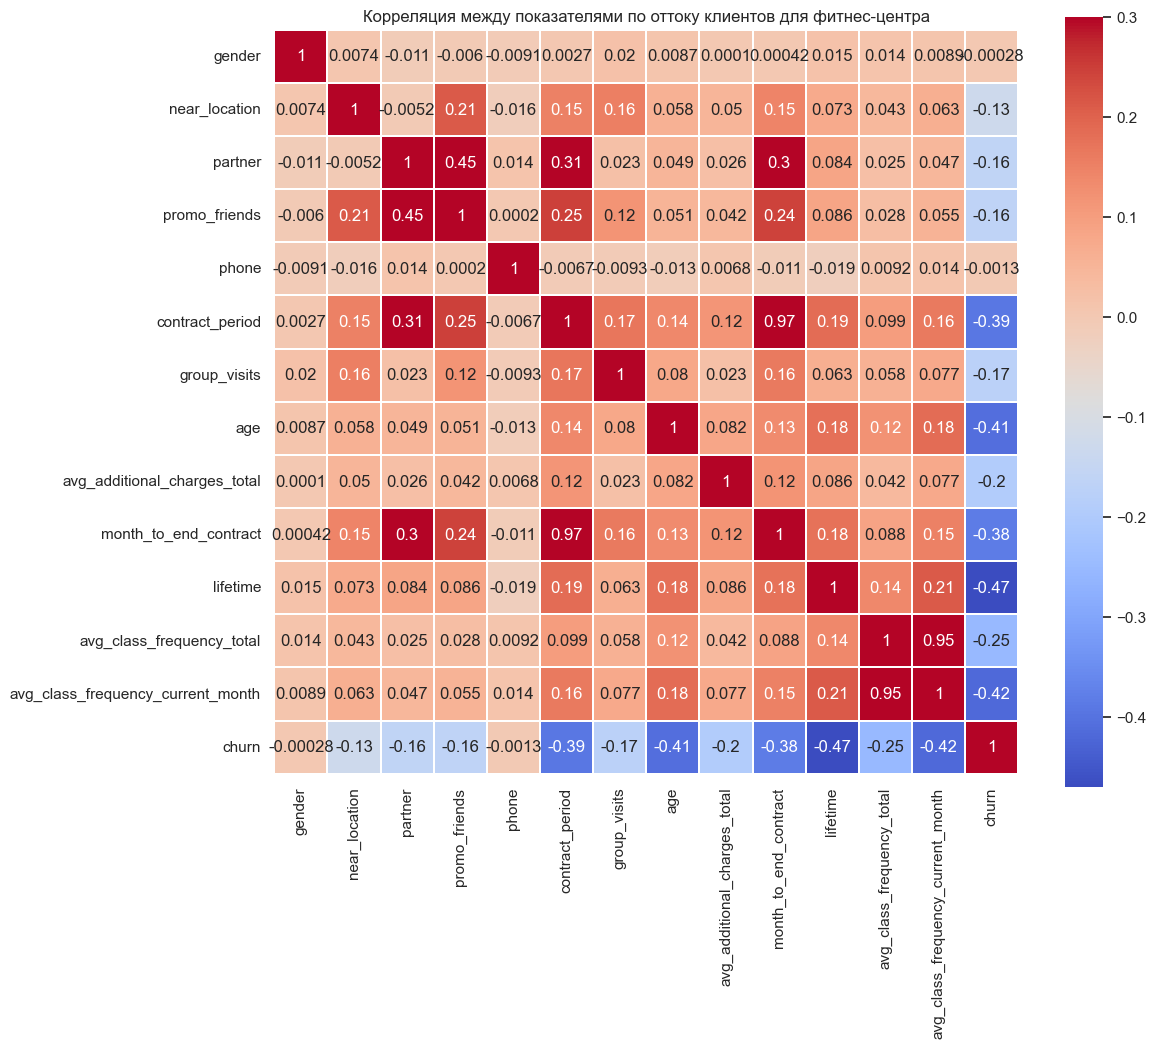

In [19]:
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    plt.title('Корреляция между показателями по оттоку клиентов для фитнес-центра')
    ax = sns.heatmap(clean_data.corr(), cbar = True, vmax=.3, square=True, annot=True, linewidths=.3, cmap='coolwarm')

- Матрица корреляции показывает, что такие признаки как пол и наличие контактного телефона почти не влияют на конечный показатель оттока. Такие признаки как: `contract_period`, `age`, `lifetime`,  `avg_class_frequency_current_month` `avg_class_frequency_total` оказывают умеренное влияние на показатель оттока. Остальные признаки имеют слабое влияние на отток, с коэффициентом корреляции не превышающим 0.3. Явно влияющих на отток признаков, предварительный анализ не выделил.   
- Сильная корреляция между признаками наблюдается только в двух случаях: коффициент коррелиции 0.97 между показателями длительности абонемента и количеством месяцев до конца абонемента и 0.95 между средней частотой посщений в неделю с начала пользования услугами и за предыдущий месяц. Такое сильное взаимное влияние параметров может привести к искажениям коэффициентов в процессе обучения модели, чтобы избежать этого, удалим из набора признаки `month_to_end_contract` и `avg_class_frequency_total`.

In [20]:
clean_data = clean_data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)
clean_data.shape

(3929, 12)

#### Вывод: <a id='conclusion2'></a>

Первичный анализ показал отсутствие в данных значительныех выбросов. В данных прослеживается две категории - поля с непрерывными значениями и бинарными значениями признаков. Непрерывные величины распределяются следующим образом:

- Средняя длительность абонемента - 4,5 месяца, медианная - 1 месяц, максимальная - 1 год, стандартное отклонение - более 4 месяцев. 
- Средний и медианный возраст клиента - 29 лет, максимальный - 41 год, минимальный - 18 лет. Стандартное отклонение - чуть более 3-х лет. 
- Средняя выручка дополнительных услуг на одного клиента - 146, медианная - 136, максимальная - 552, стандартное отклонение - 96.3. 
- Средний срок до окончания абонемента на момент опроса - чуть более 4 месяцев, минимальный и медианный - 1 месяц, максимальный - 12 месяцев, стандартное отклонение - более 4 месяцев. 
- Среднее время с момента первого посещения почти 4 месяца, медианное - 3 месяца, минимальное - 0 месяцев, это новые клиенты. - Наибольшее время с момента первого посещения составляет 31 месяц, стандартное отклонение - почти 4 месяца. 
- В текущем месяце средняя частота посещений - 1.7 раза в неделю, медианная - тоже 1.7 раза в неделю, минимальная - 0, максимальная - 6 раз. Общее среднее число посещений в неделю - 1.8, медианное также 1.8. В остальном схоже с показателями текущего месяца.

Распределение бинарных значений:    

- Клиенты распредилены по полу практически поровну - 49% и 51%
- 84% клиентов живут или работают поблизости от фитнес-центров сети
- Почти 49% клиентов посещают фитнес-центр по партнёрской программе
- 30% клиентов пришли по рекомендации друзей, 90% клиентов указали в анкете свой телефон
- 41% клиентов посещали групповые занятия
- Отток клиентов в текущем месяце составил 26.5%

В данных были обнаружены одиночные выбросы, которые могут привести к переобучению модели на крайних значениях, чтобы избежать этого, был удлалён 71 пользователь с аномальными значениями больше 99 квантиля. Оставшаяся выборка сохранила репрезентативность.

Сравнение средних показателей непрерывных величин для лояльных клиентов и клиентов из оттока дало следующий результат:    

- Ушедшие клиенты в основном с небольшим перидом контракта - 1.7 месяца. Оставшиеся - с более длительным периодом контракта-  5.7 месяцев. Возможно ушедшие брали небольшие длительности контрактов, чтобы оценить свои возможности и качество услуг заведения.
- Средний возраст оставшихся клиентов чуть выше ушедших - примерно 30 и 27 лет, похоже с возрастом люди более стабильно придерживаются своих планов.  
- Если смотреть на траты на допуслуги фитнес-центра, то видим, что среди ушедших средние траты были примерно 115 , а среди оставшихся - 156. Кажется лояльные пользователи выгоднее для фитнес-центра, но если посмотреть на среднее значение параметра количества месяцев до конца контракта, то у лояльных клиентов оно составляет 5.3, а у ушедших в отток 1.6, то есть, клиенты оттока выгодны тем, что платят но не занимают место в зале и на их место можно привлечь новых посетителей. 
- Средний лайфтайм ушедших клиентов - меньше месяца. Возможно чтобы его повысить нужно проработать стратегию удержания новых клиентов. Лояльные клиенты в среднем показывают лайфтайм 4.4 месяца.
- Средняя частота посещений в неделю в текщем месяце у оставшихся в два раза больше чем у ушедших (2 раза в неделю против 1 раза в неделю). Возможно клиентам из оттока сложнее вписать регулярное посещение зала в свой график, за всё время наблюдений картина для них улучшается - соотношение 2 раза в неделю против 1.4, но общая тенденция сохраняется

На основе анализа графиков распределения непрерывных значений признаков для клиентов из оттока и лояльных клиентов были сделаны следующие выводы:    

- Распределение длительности действующего абонемента по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего, меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. А для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.   
- По среднему возрасту обе группы имеют нормальное распределение. Как и со средними значениями, график показывает, что чаще лояльные клиенты имеют больший возраст, чем ушедшие.   
- Распределение средней выручки от других услуг фитнес-центра подтверждает вывод по средним значениям, что лояльные клиенты больше тратят на дополнительные услуги в фитнес-центре.   
- Распределение времени с момента первого обращения для ушедших в отток клиентов сильно смещено влево и редко достигает высоких значений, а для лояльных клиентов характерны более высокие значения лайфтайма.   
- Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц.   


Распределение значений в полях `avg_class_frequency_total`, `avg_class_frequency_current_month`, `lifetime`, `avg_additional_charges_total` близко к нормальному, их графики позволили сделать предположение, что величины этих параметров больше у лояльных пользователей, чем у пользователей из оттока.  На основании этого предположения были сформулированы гипотезы,
проверка которых подтвердила, что лояльные пользователи чаще посещают фитнес-центр чем ушедшие в отток как в текущем месяце, так и за всё время наблюдений. Лайфтайм и выручка от доп. услуг также выше у лояльных пользователей.    

На основе анализа столбчатых графиков бинарных признаков для клиентов из оттока и лояльных клиентов, можно сделать следующие выводы:

- По полу, близости к фитнес-центру, наличию контактного телефона обе группы имеют схожее равномерное распределение.   
- Есть различия в распределении групп между теми, кто является сотрудником компании-партнёра клуба и не является. Процент клиентов, уходящих в отток выше на 20% среди участников партнёрской программы. 
- Клиенты, посещающие групповые занятия, также на 20% более склонны к оттоку, чем занимающиеся индивидуально.    
- Процент оттока среди участников промо-акции "Приведи друга" клиентов больше на 15%, но распределения схожи.   

Анализ матрицы корреляции показал, что такие признаки как пол и наличие контактного телефона почти не влияют на конечный показатель оттока. Остальные показатели имеют слабое влияние на отток, с коэффициентом корреляции не превышающим 0.5. Явно влияющих на отток признаков, предварительный анализ не выделил.   

Сильная корреляция между признаками наблюдается только в двух случаях: коффициент коррелиции 0.97 между показателями длительности абонемента и количеством месяцев до конца абонемента и 0.95 между средней частотой посщений в неделю с начала пользования услугами и за предыдущий месяц. Такое сильное взаимное влияние параметров может привести к искажениям коэффициентов в процессе обучения модели, чтобы избежать этого, из выборки были удалены признаки `month_to_end_contract` и `avg_class_frequency_total`.

### Модель прогнозирования оттока <a id='predict'></a>

Для подготовки к работе с моделями обучения зададим список моделей, выберем метрики проверки моделей, и подготовим датафрейм для хранения результатов  

In [21]:
# Выбираем модели
model_list = ['LogisticRegression', 'RandomForestClassifier']
# Выбираем метрики
metrics_dict = {'accuracy': accuracy_score,
                'precision': precision_score,
                'recall' : recall_score, 
                'f1' : f1_score, 
                'roc_auc' : roc_auc_score}
# Формируем датафрейм для хранения результатов
result = pd.DataFrame(columns=[key for key in metrics_dict])
result.reset_index(inplace = True)
result = result.rename(columns= {'index': 'model'})
result['model'] = model_list

Зададим функцию расчёта метрик

In [22]:
def metrics_calculator(m_name, m_probabilities, m_predictions, y_control):
    for key in metrics_dict:
        if key == 'roc_auc':
            result.loc[result['model'] == m_name, key] = metrics_dict[key](y_control, m_probabilities).round(3)
        else:
            result.loc[result['model'] == m_name, key] = metrics_dict[key](y_control, m_predictions).round(3)

Разделим данные на признаки и целевой параметр

In [23]:
y = clean_data['churn']
X = clean_data.drop(['churn'], axis=1)

Разделим выборку на обучающую и валидационную и стандартизируем

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

**Модель логистической регрессии**    
На первом этапе обучим модель логистической регрессии и посмотрим значения метрик качества модели

In [25]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_st, y_train)
probabilities = model.predict_proba(X_test_st)[:,1]
predictions = model.predict(X_test_st)

# Вносим значения метрик в таблицу с результатами
metrics_calculator('LogisticRegression', probabilities, predictions, y_test)

#таблица с результатами
result.loc[result['model'] == 'LogisticRegression']

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.905,0.878,0.771,0.821,0.969


Для логистической регрессии метрики показали достаточно высокий уровень качества модели, посмотрим, как с задачей справится следующая модель

**Модель случайного леса**    
На следующем этапе используем модель случайного леса из ансамбля деревьев и посмотрим метрики обеих моделей 

In [26]:
model = RandomForestClassifier(n_estimators = 100, random_state=42)
model.fit(X_train_st, y_train)
probabilities = model.predict_proba(X_test_st)[:,1]
predictions = model.predict(X_test_st)

# Вносим значения метрик в таблицу с результатами
metrics_calculator('RandomForestClassifier', probabilities, predictions, y_test)

#таблица с результатами
result

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.905,0.878,0.771,0.821,0.969
1,RandomForestClassifier,0.896,0.894,0.717,0.796,0.96


Обе модели показали достаточно высокое качество прогнозов. Модель логистической регрессии показала более высокие метрики accuracy = 0.905, recall = 0.771, f1=  0.821 и roc_auc = 0.969. Случайный лес оказался лучше только в метрике precision = 0.894

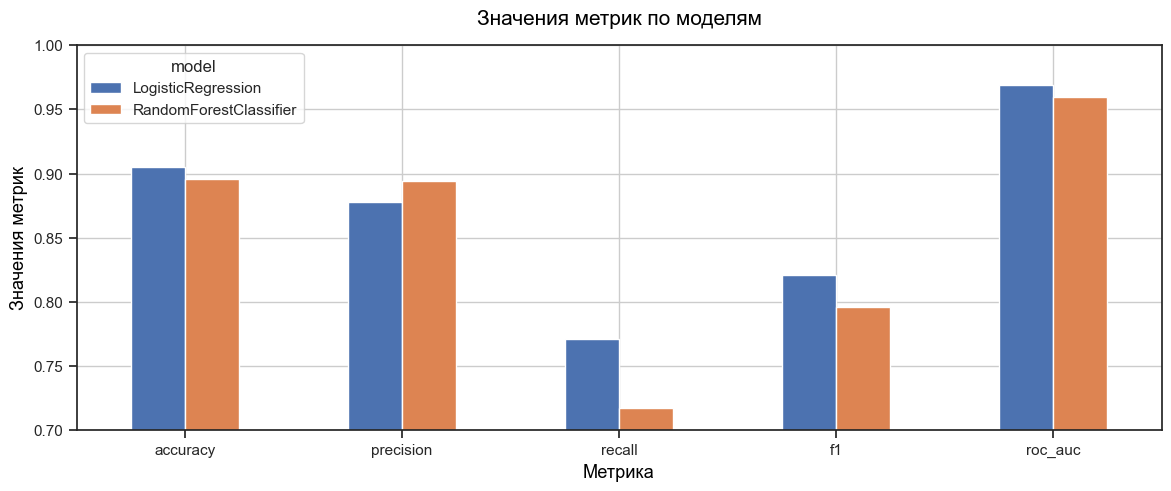

In [27]:
draw_result = result.copy()
draw_result = draw_result.set_index('model').T

draw_result.plot(y=['LogisticRegression', 'RandomForestClassifier'], kind='bar', \
        grid=True, legend=True, ylim=(0.7, 1), figsize=(14, 5))
plt.title('Значения метрик по моделям', loc ='center', pad = 15, fontsize=15, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Метрика', fontsize=13, color='black')
plt.ylabel('Значения метрик', fontsize=13, color='black')
plt.xticks(rotation=0, ha='center')
plt.show()

Значения метрик для двух моделей очень близки, но модель логистической регрессии немного точнее отражает взаимосвязь признаков с целевым параметром, поэтому для использования в целях прогнозирования оттока клиентов она выглядит предпочтительнее

#### Вывод: <a id='conclusion3'></a>

Для работы с моделями машинного обучения, выборка была разделена на обучащую и валидационную в соотношении 80 к 20, после чего данные были стандартизированы и переданы на обработку двум моделям: алгоритму логистической регрессии и алгоритму случайного леса. Для проверки качества моделей по результатам были расчитаны метрики:  доля правильных ответов (accuracy), точность (precision), полнота (recall) и метрика оценки качества классификатора ROC_AUC.

По результатам обучения были получены следующие значения метрик:   

|model |	accuracy |	precision |	recall |	f1 |	roc_auc |
| --- | --- | --- | --- | --- | --- |
|LogisticRegression |	0.905 |	0.878 |	0.771 |	0.821 |	0.969 |
|RandomForestClassifier |	0.896 |	0.894 |	0.717 |	0.796 |	0.96|

Обе модели показали достаточно высокое качество прогнозов. Модель логистической регрессии показала более высокие метрики accuracy = 0.905, recall = 0.771, f1=  0.821 и roc_auc = 0.969. Случайный лес оказался лучше только в метрике precision = 0.894.
Значения метрик для двух моделей очень близки, но модель логистической регрессии немного точнее отражает взаимосвязь признаков с целевым параметром, поэтому для использования в целях прогнозирования оттока клиентов она выглядит более предпочтительной

### Кластеризация клиентов <a id='cluster'></a>

Отложим в сторону столбец с оттоком и проведём кластеризацию клиентов по признакам

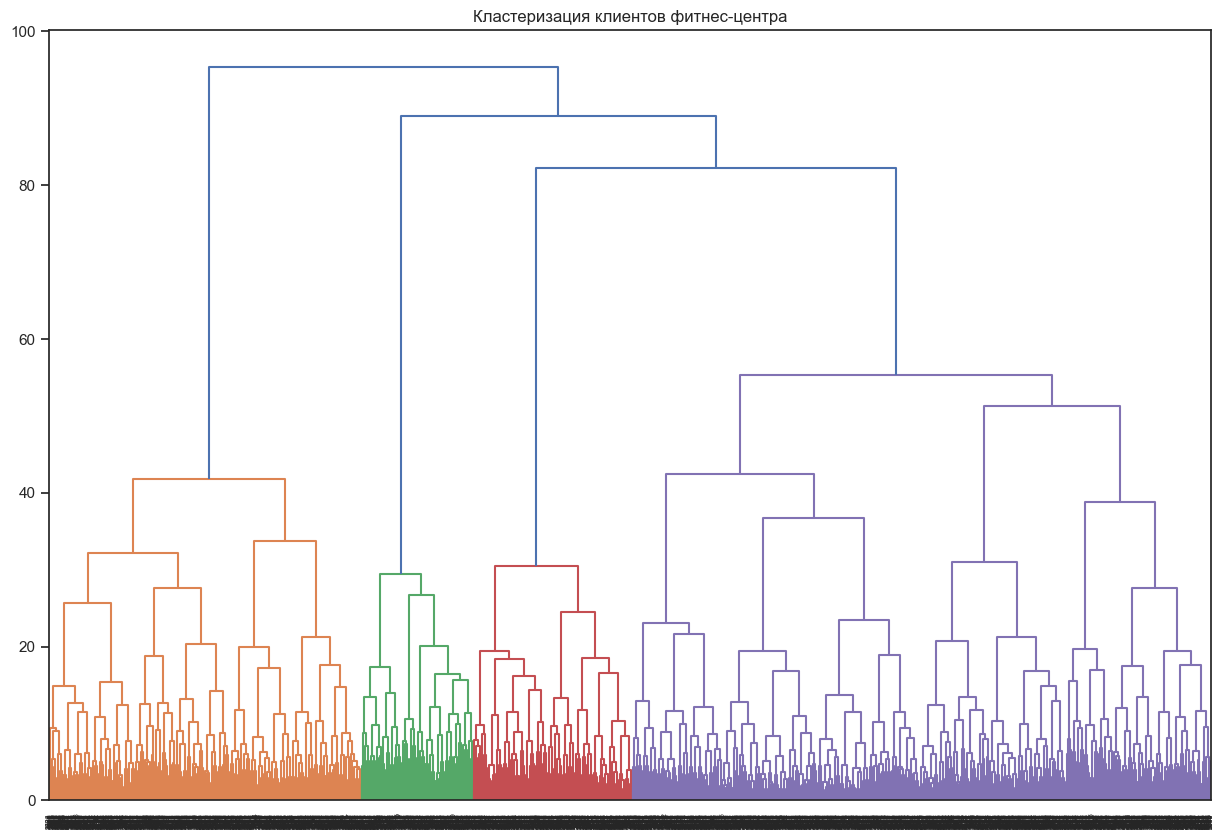

In [28]:
cluster_data = clean_data.drop(['churn'], axis=1)

sc = StandardScaler()
x_sc = sc.fit_transform(cluster_data)

linked = linkage(x_sc, method = 'ward') 
#В переменной linked сохранена таблица «связок» между объектами. Её можно визуализировать как дендрограмму:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-центра')
plt.show() 

Основываясь на дендрограмме выделим пять кластеров в данных.

Далее обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов  

In [29]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
clean_data['client_cluster'] = labels

# считаем размеры кластеров
cluster_volume = clean_data.pivot_table(index='client_cluster', values='age', aggfunc='count')
cluster_volume.columns = ['cluster_size']

# выводим статистику по средним значениям наших признаков по кластеру и его размер
cluster_features = clean_data.groupby('client_cluster').mean()
cluster_features = cluster_features.join(cluster_volume)
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

client_cluster,0,1,2,3,4
gender,0.50,0.49,0.50,0.56,0.50
near_location,1.00,1.00,1.00,1.00,0.00
partner,0.38,0.95,0.23,0.28,0.49
promo_friends,0.05,1.00,0.13,0.07,0.08
phone,0.90,0.91,0.90,0.90,0.91
contract_period,5.09,7.39,1.77,5.15,3.00
group_visits,0.00,0.53,0.18,1.00,0.23
age,30.30,29.64,26.86,30.27,28.69
avg_additional_charges_total,173.25,154.02,109.91,153.27,134.17
lifetime,4.97,4.20,1.32,4.07,2.91


Таблица показывает наличие выраженных характерных признаков кластеров, посмотрим их подробнее на графиках. Начнём с построения  столбчатых диаграмм для бинарных параметров.

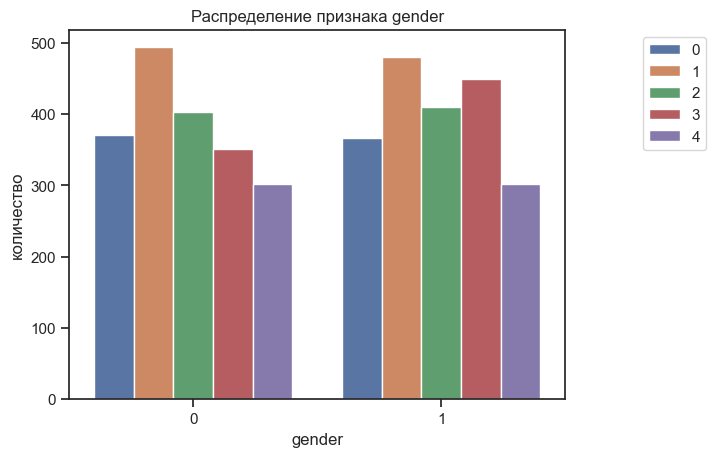

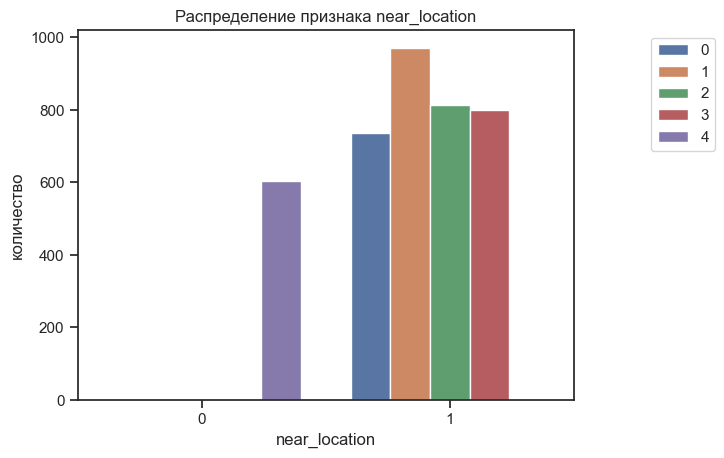

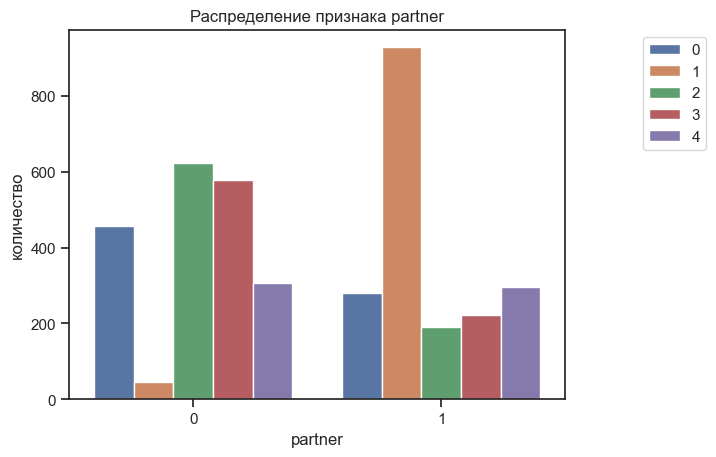

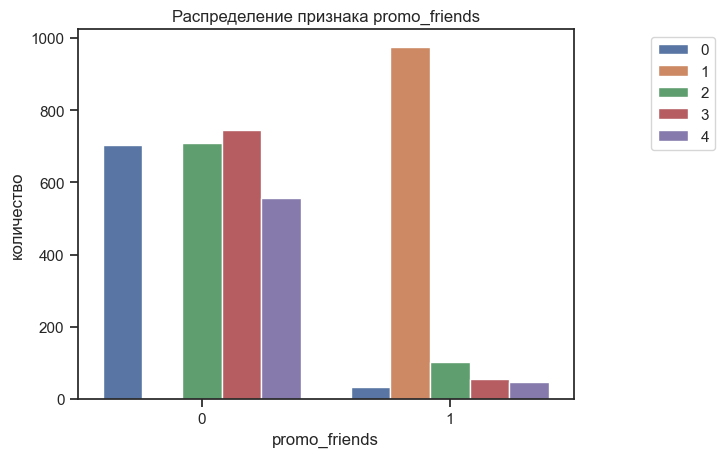

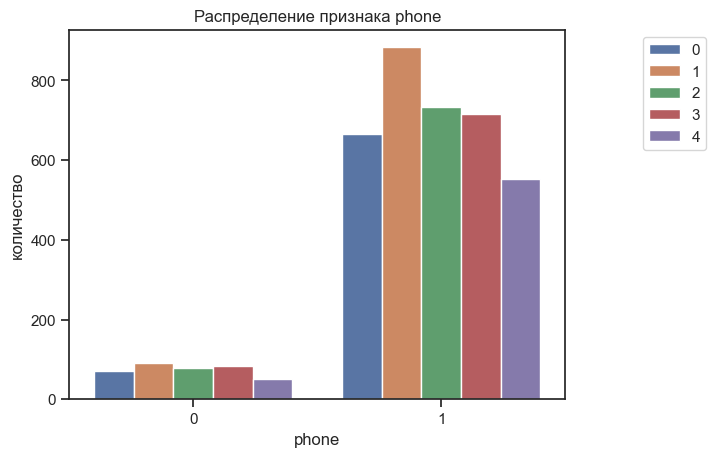

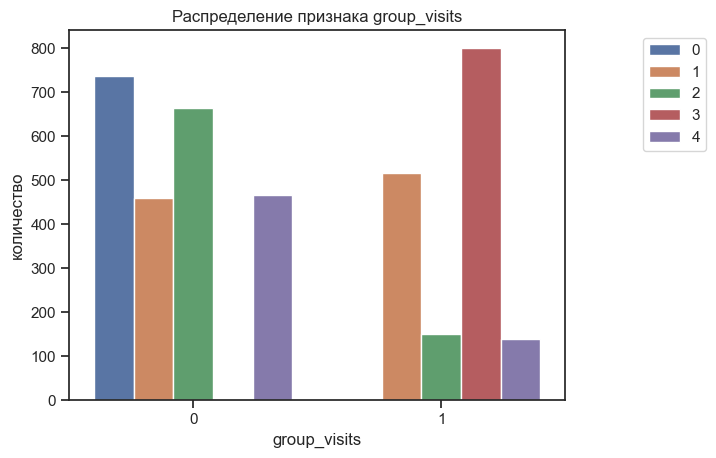

In [30]:
fig, ax = plt.subplots()
for column in boolean_columns:
    plt.title('Распределение признака '+column)
    sns.countplot(data=clean_data, x=column, hue='client_cluster')
    plt.xlabel(column)
    plt.ylabel('количество')
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()

- **Кластер 0**    
Размер кластера средний, количество мужчин и женщин одинаково.    
Клиенты проживают или работают в районе, где находится фитнес-центр.    
Клиенты распределены в соотношении: 2/3 - обычных клиентов, 1/3 -сотрудники компании-партнёра клуба.    
Большинство клиентов пришли не в рамках акции «приведи друга».   
Большинство клиентов оставили контактный телефон.    
Посещение групповых занятий: никто из клиентов не посещает групповые занятия.    
- **Кластер 1**    
Самый большой по численности кластер, количество представителей обоих полов одинаковое.    
Клиенты проживают или работают в районе, где находится фитнес-центр.    
Большинство клиентов - сотрудники компании-партнёра клуба, обычных клиентов незначительное количество.    
Все клиенты пришли в рамках акции «приведи друга».    
Большинство клиентов оставили контактный телефон.    
Посещение групповых занятий: примерно одинаковое количество посещаюющих и не посещающих.    
- **Кластер 2**    
Средний по размеру кластер, в нём одинкаовое количество представителей обоих полов.     
Клиенты проживают или работают в районе, где находится фитнес-центр.    
Клиенты распределены в соотношении: 1/4 - сотрудники компании-партнёра клуба, 3/4 обычных клиентов.    
Большинство клиентов пришли не в рамках акции «приведи друга».    
Большинство клиентов оставили контактный телефон.    
Посещение групповых занятий: большинство клиентов не посещают групповые занятия.    
- **Кластер 3**    
Средний по размеру кластер, в нём чуть больше представителей пола "1".    
Клиенты проживают или работают в районе, где находится фитнес-центр.    
Клиенты распределены в соотношении: 1/4 - сотрудники компании-партнёра клуба, 3/4 обычных клиентов.    
Большинство клиентов пришли не в рамках акции «приведи друга».    
Большинство клиентов оставили контактный телефон.    
Посещение групповых занятий: все клиенты посещают групповые занятия.    
- **Кластер 4**     
Самый малочисленный кластер с примерно одинаковым количеством представителей обоих полов.    
Клиенты не проживают и не работают в районе, где находится фитнес-центр.    
Одинаковое количество сотрудников компании-партнёра клуба и обычных клиентов.    
Большинство клиентов пришли не в рамках акции «приведи друга».    
Большинство клиентов оставили контактный телефон.    
Посещение групповых занятий: большинство клиентов не посещают групповые занятия.    

Далее построим боксплоты для непрерывных и дискретных переменных

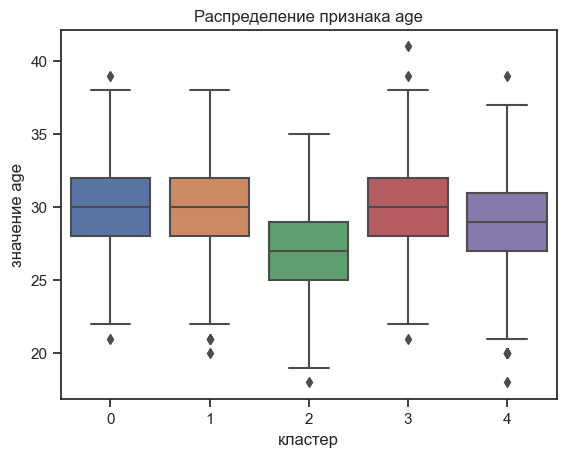

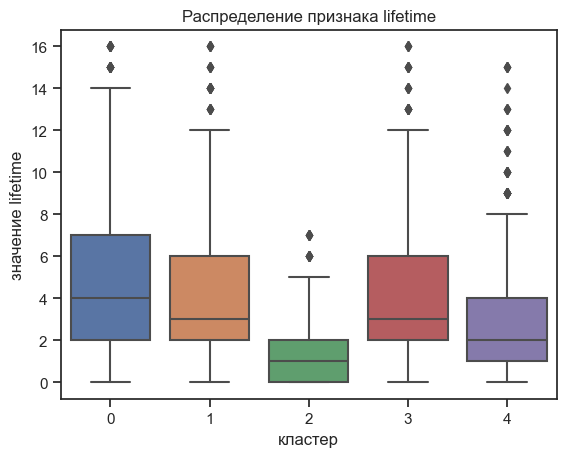

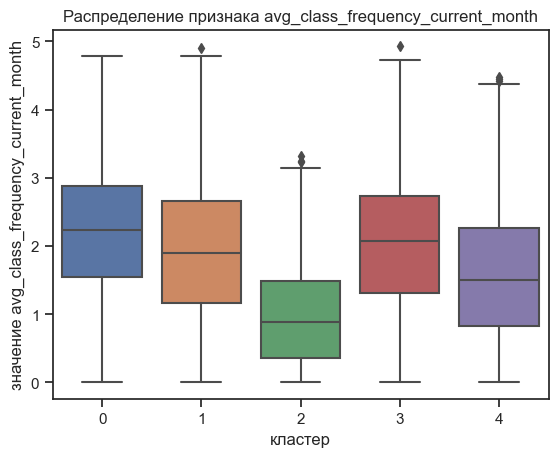

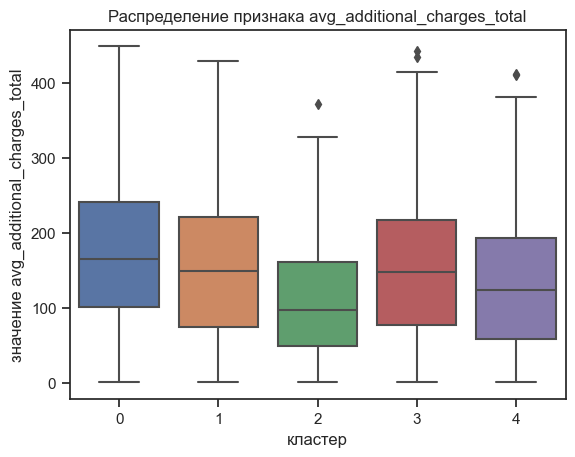

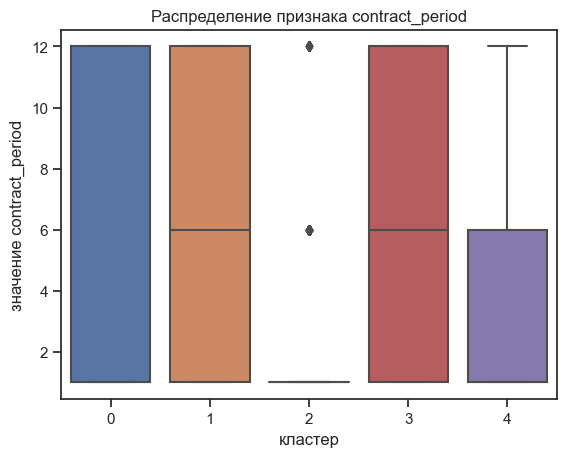

In [31]:
# Строим график для непрерывных и дискретных величин
cont_values = ['age', 'lifetime', 'avg_class_frequency_current_month', 'avg_additional_charges_total', 'contract_period']
fig, ax = plt.subplots()
for column in cont_values:
    plt.title('Распределение признака '+column)
    sns.boxplot(x='client_cluster', y=column, data=clean_data)
    plt.xlabel('кластер')
    plt.ylabel('значение '+column)
    plt.show()

- **Кластер 0**    
Средний возраст примерно 30.3 года.    
Время с момента первого обращения в фитнес-центр - 5 месяцев.    
Средняя частота посещений в неделю за предыдущий месяц - 2.2.        
Тратит на доп. услуги в среднем 173.    
Средняя длительность контракта - 5 месяцев.    
- **Кластер 1**    
Средний возраст примерно 29.6 лет.    
Время с момента первого обращения в фитнес-центр - 4.2 месяца.    
Средняя частота посещений в неделю за предыдущий месяц - 1.9.    
Тратит на доп. услуги в среднем 154.    
Средняя длительность контракта - 7.4 месяца.    
- **Кластер 2**    
Средний возраст примерно 26.8 лет.    
Время с момента первого обращения в фитнес-центр - 1.3 месяца.    
Средняя частота посещений в неделю за предыдущий месяц - 1.    
Тратит на доп. услуги в среднем 110.    
Средняя длительность контракта - 1.7 месяца.    
- **Кластер 3**    
Средний возраст почти 30.3 лет.    
Время с момента первого обращения в фитнес-центр - 4 месяца.    
Средняя частота посещений в неделю за предыдущий месяц - 2.    
Тратит на доп. услуги в среднем 153.     
Средняя длительность контракта - 5 месяцев.    
- **Кластер 4**    
Средний возраст около 28.7 лет.    
Время с момента первого обращения в фитнес-центр - 3 месяца.    
Средняя частота посещений в неделю за предыдущий месяц - 1.6.    
Тратит на доп. услуги в среднем 134.     
Средняя длительность контракта - 3 месяца.    

Определим процент оттока по кластерам

In [32]:
cluster_churn = clean_data.pivot_table(index='client_cluster', values='churn',
                                       aggfunc='mean').sort_values(by='churn', ascending=False)
cluster_churn['churn'] = cluster_churn['churn'].apply(lambda x: f'{x:.2%}')
cluster_churn

,churn
client_cluster,
2,75.03%
4,40.73%
1,10.26%
3,9.25%
0,4.21%


Клиенты из второго кластера больше всего склоны к оттоку - 75%, вот мы и нашли логово зла, светлая сторона представлена нулевым кластером, в нём отток составляет 4%. Приспешниками тёмной стороны являются и клиенты из четвёртого кластера, отток среди них составляет 40%. Клиенты первого и третьего кластера, напротив тяготеют к светлой стороне с оттоком окло 10%. Посмотрим значения оттока на графике

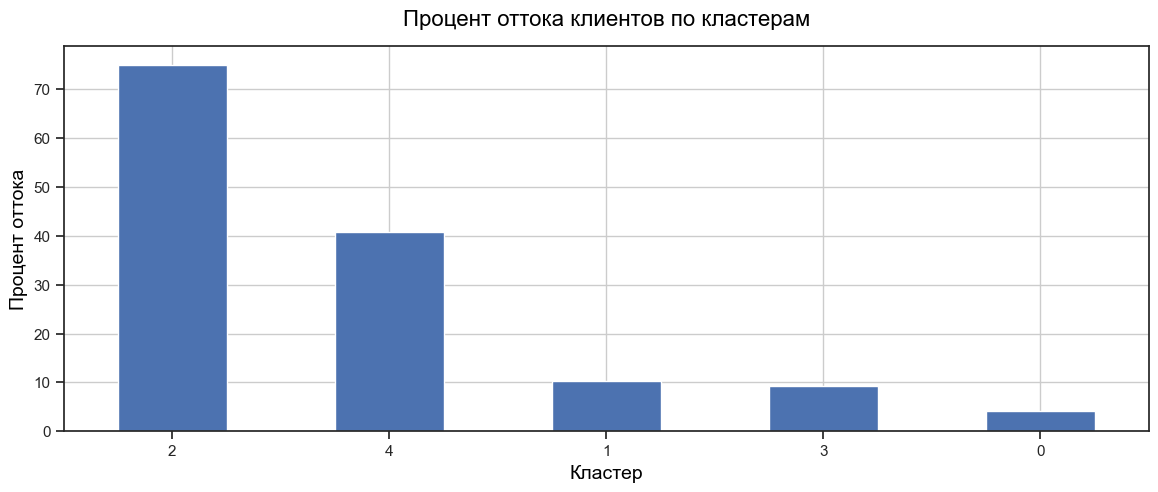

In [33]:
cluster_churn.reset_index(inplace=True)
cluster_churn.columns = ['client_cluster', 'churn']
cluster_churn['churn'] = cluster_churn['churn'].apply(lambda x: float(x.replace('%', '')))
cluster_churn.plot(x='client_cluster', y='churn', kind='bar', figsize=(14,5), legend=False)
plt.title('Процент оттока клиентов по кластерам', loc ='center', pad = 15, fontsize=16, \
             color='black', backgroundcolor='white', fontstyle='normal')
plt.xlabel('Кластер', fontsize=14, color='black')
plt.ylabel('Процент оттока', fontsize=14, color='black')
plt.xticks(rotation=0, ha='center')
plt.grid()
plt.show()

На графике прослеживается две группы кластеров по уровню оттока:     
- Лояльные кластеры - нулевой, первый и третий.
- Проблемные кластеры - второй и четвёртый.

#### Вывод: <a id='conclusion4'></a>

По признакам клиентов построили дендрограмму, на онове которой было выделено пять кластеров в данных. На основе алгоритма K-Means обучили модель кластеризации и спрогнозировали кластеры клиентов. Чтобы изучить особенности клиентов, для кластеров были посчитаны средние значения и построены графики распределения значений. По уровню оттока кластеры разделились на две группы: лояльные и проблемные.

Основные характеристики кластеров:    

**1. Лояльные кластеры**    

- **Наиболее лояльные клиенты предствлены нулевым кластером (отток - 4.2%):**    
Кластер имеет средний размер и равное количество мужчин и женщин в составе.    
Портрет представителя класса: Проживает или работает в районе, где находится фитнес-центр. 1/3 - сотрудники компании-партнёра, 2/3 - обычные клиенты. Большинство клиентов пришли не в рамках акции «приведи друга» и оставили контактный телефон. Никто из них не посещает групповые занятия. Средний возраст примерно 30.3 года (самые возрастные). Время с момента первого обращения в фитнес-центр - 5 месяцев (самый большой лайфтайм). Средняя частота посещений в неделю за предыдущий месяц - 2.2 (самая высокая среди кластеров). Тратит на доп. услуги в среднем 173 (самые высокие траты на доп. услуги). Средняя длительность контракта - 5 месяцев (не самое высокое значение, но показатель хороший).    
- **Третий кластер также состоит из довольно стабильных клиентов (отток - 9.3%):**    
Это средний по размеру кластер, в нём чуть больше представителей пола "1". Клиенты проживают или работают в районе, где находится фитнес-центр, 1/4 из них - сотрудники компании-партнёра клуба, 3/4 - обычные клиенты. Большинство клиентов пришли не в рамках акции «приведи друга» и оставили контактный телефон. Все клиенты посещают групповые занятия, а их средний возраст почти 30.3 лет. Время с момента первого обращения в фитнес-центр - 4 месяца со средней частотой посещений в неделю за предыдущий месяц - 2. Тратитят на доп. услуги в среднем 153 (хорошее среднее значение). Средняя длительность контракта - 5 месяцев (хорошее среднее значение).    
- **Первый кластер можно также отнести к лояльным (отток - 10.3%):**    
Самый большой по численности кластер, количество представителей обоих полов одинаковое.    
Клиенты проживают или работают в районе, где находится фитнес-центр, все они пришли в рамках акции «приведи друга», и    
большинство из них - сотрудники компании-партнёра клуба, обычных клиентов незначительное количество. Примерно одинаковое количество тех кто посещают и не посещают групповые занятия, большинство из них оставили контактный телефон.    
Средний возраст примерно 29.6 лет. Время с момента первого обращения в фитнес-центр - 4.2 месяца. Средняя частота посещений в неделю за предыдущий месяц - 1.9. Тратит на доп. услуги в среднем 154 (хорошее среднее значение). Средняя длительность контракта - 7.4 месяца (самая высокая).    

**2. Проблемные кластеры**

- **Четвёртый кластер относится к проблемным (отток - 40.7%):**    
Самый малочисленный кластер с примерно одинаковым количеством представителей обоих полов.    
Клиенты не проживают и не работают в районе, где находится фитнес-центр. Одинаковое количество сотрудников компании-партнёра клуба и обычных клиентов. Большинство клиентов пришли не в рамках акции «приведи друга» и оставили контактный телефон.    
Посещение групповых занятий: большинство клиентов не посещают групповые занятия. Средний возраст около 28.7 лет (более молодая группа). Время с момента первого обращения в фитнес-центр - 3 месяца (довольно небольшой лайфтайм). Средняя частота посещений в неделю за предыдущий месяц - 1.6 (частота ниже средней). Тратит на доп. услуги в среднем 134 (траты ниже средних). Средняя длительность контракта - 3 месяца (значение ниже, чем у лояльных кластеров).    

- **Второй кластер является худшим по удержанию клиентов (отток составляет - 75%(!)):**
Средний по размеру кластер, в нём одинкаовое количество представителей обоих полов. Клиенты проживают или работают в районе, где находится фитнес-центр, 1/4 из них - сотрудники компании-партнёра клуба, 3/4 обычные клиенты. Большинство клиентов пришли не в рамках акции «приведи друга» и оставили контактный телефон. Большинство клиентов не посещают групповые занятия. Средний возраст примерно 26.8 лет. Время с момента первого обращения в фитнес-центр - 1.3 месяца. Средняя частота посещений в неделю за предыдущий месяц - 1. Тратят на доп. услуги в среднем 110. Средняя длительность контракта - 1.7 месяца. Самые низкие из кластеров показатели возраста, лайфтайма, частоты посещений, трат на доп. услуги, длительности контракта.    

### Результаты исследования <a id='result'></a>

Исследование проводилось на основе данных, предоставленных фитнес-центром, содержащих 4000 записей о клиентах. Данные состоят из 13 полей с признаками и целевым полем с фактором оттока. Загрузка данных прошла без ошибок, данные в столбце `month_to_end_contract` преведены к типу 'int64', остальные типы данных в таблице соответствовали содержащейся в столбцах информации, дубликаты и пропуски отсутствовали. Названия столбцов преведены к змеиному регистру. Выборка является достаточной для проведения исследования, данные готовы анализа.

**EDA**

Первичный анализ показал отсутствие в данных значительныех выбросов. В данных прослеживается две категории - поля с непрерывными/дискретными значениями и поля с бинарными значениями признаков. Непрерывные/дискретные величины распределяются следующим образом:

- Средняя длительность абонемента - 4,5 месяца, медианная - 1 месяц, максимальная - 1 год, стандартное отклонение - более 4 месяцев. 
- Средний и медианный возраст клиента - 29 лет, максимальный - 41 год, минимальный - 18 лет. Стандартное отклонение - чуть более 3-х лет. 
- Средняя выручка дополнительных услуг на одного клиента - 146, медианная - 136, максимальная - 552, стандартное отклонение - 96.3. 
- Средний срок до окончания абонемента на момент опроса - чуть более 4 месяцев, минимальный и медианный - 1 месяц, максимальный - 12 месяцев, стандартное отклонение - более 4 месяцев. 
- Среднее время с момента первого посещения почти 4 месяца, медианное - 3 месяца, минимальное - 0 месяцев, это новые клиенты. - Наибольшее время с момента первого посещения составляет 31 месяц, стандартное отклонение - почти 4 месяца. 
- В текущем месяце средняя частота посещений - 1.7 раза в неделю, медианная - тоже 1.7 раза в неделю, минимальная - 0, максимальная - 6 раз. Общее среднее число посещений в неделю - 1.8, медианное также 1.8. В остальном схоже с показателями текущего месяца.

Распределение бинарных значений:    

- Клиенты распредилены по полу практически поровну - 49% и 51%
- 84% клиентов живут или работают поблизости от фитнес-центров сети
- Почти 49% клиентов посещают фитнес-центр по партнёрской программе
- 30% клиентов пришли по рекомендации друзей, 90% клиентов указали в анкете свой телефон
- 41% клиентов посещали групповые занятия
- Отток клиентов в текущем месяце составил 26.5%

В данных были обнаружены одиночные выбросы, которые могли привести к переобучению модели на крайних значениях, чтобы избежать этого, был удалён 71 пользователь с аномальными значениями больше 99 квантиля. Оставшаяся выборка сохранила репрезентативность.

На следующем этапе выборка была сгруппирована по фактору оттока, чтобы посмотреть особенности лояльных клиентов и ушедших, сравнение средних показателей небинарных величин для лояльных клиентов и клиентов из оттока дало следующий результат:    

- Ушедшие клиенты в основном с небольшим перидом контракта - 1.7 месяца. Оставшиеся - с более длительным периодом контракта-  5.7 месяцев. Возможно ушедшие брали небольшие длительности контрактов, чтобы оценить свои возможности и качество услуг заведения.
- Средний возраст оставшихся клиентов чуть выше ушедших - примерно 30 и 27 лет, соответственно, похоже с возрастом люди более стабильно придерживаются своих планов.  
- Если смотреть на траты на допуслуги фитнес-центра, то видим, что среди ушедших средние траты были примерно 115 , а среди оставшихся - 156. Кажется лояльные пользователи выгоднее для фитнес-центра, но если посмотреть на среднее значение параметра количества месяцев до конца контракта, то у лояльных клиентов оно составляет 5.3, а у ушедших в отток 1.6, то есть, клиенты оттока выгодны тем, что платят но не занимают место в зале и на их место можно привлечь новых посетителей. 
- Средний лайфтайм ушедших клиентов - меньше месяца. Возможно чтобы его повысить нужно проработать стратегию удержания новых клиентов. Лояльные клиенты в среднем показывают лайфтайм 4.4 месяца.
- Средняя частота посещений в неделю в текщем месяце у оставшихся в два раза больше чем у ушедших (2 раза в неделю против 1 раза в неделю). Возможно клиентам из оттока сложнее вписать регулярное посещение зала в свой график, за всё время наблюдений картина для них улучшается - соотношение 2 раза в неделю против 1.4, но общая тенденция сохраняется

На основе анализа графиков распределения небинарных значений признаков для клиентов из оттока и лояльных клиентов были сделаны следующие выводы:    

- Распределение длительности действующего абонемента по оставшимся пользователям и ушедшим различается. Лояльных клиентов, приобретающих абонемент на 1 месяц больше всего, меньше их сроком на год, и наименьшее количество клиентов - на 6 месяцев. А для ушедших в отток 1 месяц - самый популярный, затем - 6 месяцев (с очень низким числом абонементов), и практически нет абонементов на 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.   
- По среднему возрасту обе группы имеют нормальное распределение. Как и со средними значениями, график показывает, что чаще лояльные клиенты имеют больший возраст, чем ушедшие.   
- Распределение средней выручки от других услуг фитнес-центра подтверждает вывод по средним значениям, что лояльные клиенты больше тратят на дополнительные услуги в фитнес-центре.   
- Распределение времени с момента первого обращения для ушедших в отток клиентов сильно смещено влево и редко достигает высоких значений, а для лояльных клиентов характерны более высокие значения лайфтайма.   
- Распределение для средней частоты посещений в неделю за время действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц.   


Распределение значений в полях `avg_class_frequency_total`, `avg_class_frequency_current_month`, `lifetime`, `avg_additional_charges_total` близко к нормальному, их графики позволили сделать предположение, что величины этих параметров больше у лояльных пользователей, чем у пользователей из оттока.  На основании этого предположения были сформулированы гипотезы,
проверка которых подтвердила, что лояльные пользователи чаще посещают фитнес-центр чем ушедшие в отток, как в текущем месяце, так и за всё время наблюдений. Лайфтайм и выручка от доп. услуг также выше у лояльных пользователей.    

На основе анализа столбчатых графиков бинарных признаков для клиентов из оттока и лояльных клиентов, можно сделать следующие выводы:

- По полу, близости к фитнес-центру, наличию контактного телефона обе группы имеют схожее равномерное распределение.   
- Есть различия в распределении групп между теми, кто является сотрудником компании-партнёра клуба и не является. Процент клиентов, уходящих в отток выше на 20% среди участников партнёрской программы. 
- Клиенты, посещающие групповые занятия, также на 20% более склонны к оттоку, чем занимающиеся индивидуально.    
- Процент оттока среди участников промо-акции "Приведи друга" клиентов больше на 15%, но распределения схожи.   

Анализ матрицы корреляции показал, что такие признаки как пол и наличие контактного телефона почти не влияют на конечный показатель оттока. Остальные показатели имеют слабое влияние на отток, с коэффициентом корреляции не превышающим 0.5. Явно влияющих на отток признаков, предварительный анализ не выделил.   

Сильная корреляция между признаками наблюдается только в двух случаях: коффициент коррелиции 0.97 между показателями длительности абонемента и количеством месяцев до конца абонемента и 0.95 между средней частотой посщений в неделю с начала пользования услугами и за предыдущий месяц. Такое сильное взаимное влияние параметров может привести к искажениям коэффициентов в процессе обучения модели, чтобы избежать этого, из выборки были удалены признаки `month_to_end_contract` и `avg_class_frequency_total`.

**Машинное обучение**

Для работы с моделями машинного обучения, выборка была разделена на обучащую и валидационную в соотношении 80 к 20, после чего данные были стандартизированы и переданы на обработку двум моделям: алгоритму логистической регрессии и алгоритму случайного леса. Для проверки качества моделей по результатам были расчитаны метрики:  доля правильных ответов (accuracy), точность (precision), полнота (recall) и метрика оценки качества классификатора ROC_AUC.

По результатам обучения были получены следующие значения метрик:   

|model |	accuracy |	precision |	recall |	f1 |	roc_auc |
| --- | --- | --- | --- | --- | --- |
|LogisticRegression |	0.905 |	0.878 |	0.771 |	0.821 |	0.969 |
|RandomForestClassifier |	0.896 |	0.894 |	0.717 |	0.796 |	0.96|

Обе модели показали достаточно высокое качество прогнозов. Модель логистической регрессии показала более высокие метрики accuracy = 0.905, recall = 0.771, f1=  0.821 и roc_auc = 0.969. Случайный лес оказался лучше только в метрике precision = 0.894.
Значения метрик для двух моделей очень близки, но **модель логистической регрессии** немного точнее отражает взаимосвязь признаков с целевым параметром, поэтому для использования в целях прогнозирования оттока клиентов она выглядит более предпочтительной

**Кластеризация**

По признакам клиентов построили дендрограмму, на онове которой было выделено пять кластеров в данных. На основе алгоритма K-Means обучили модель кластеризации и спрогнозировали кластеры клиентов. Чтобы изучить особенности клиентов, для кластеров были посчитаны средние значения и построены графики распределения значений. По уровню оттока кластеры разделились на две группы: лояльные и проблемные.

Основные характеристики кластеров:    

**1. Лояльные кластеры**    

- **Наиболее лояльные клиенты предствлены нулевым кластером (отток - 4.2%):**    
Кластер имеет средний размер и равное количество мужчин и женщин в составе.    
Портрет представителя класса: Проживает или работает в районе, где находится фитнес-центр. 1/3 - сотрудники компании-партнёра, 2/3 - обычные клиенты. Большинство клиентов пришли не в рамках акции «приведи друга» и оставили контактный телефон. Никто из них не посещает групповые занятия. Средний возраст примерно 30.3 года (самые возрастные). Время с момента первого обращения в фитнес-центр - 5 месяцев (самый большой лайфтайм). Средняя частота посещений в неделю за предыдущий месяц - 2.2 (самая высокая среди кластеров). Тратит на доп. услуги в среднем 173 (самые высокие траты на доп. услуги). Средняя длительность контракта - 5 месяцев (не самое высокое значение, но показатель хороший).    
- **Третий кластер также состоит из довольно стабильных клиентов (отток - 9.3%):**    
Это средний по размеру кластер, в нём чуть больше представителей пола "1". Клиенты проживают или работают в районе, где находится фитнес-центр, 1/4 из них - сотрудники компании-партнёра клуба, 3/4 - обычные клиенты. Большинство клиентов пришли не в рамках акции «приведи друга» и оставили контактный телефон. Все клиенты посещают групповые занятия, а их средний возраст почти 30.3 лет. Время с момента первого обращения в фитнес-центр - 4 месяца со средней частотой посещений в неделю за предыдущий месяц - 2. Тратитят на доп. услуги в среднем 153 (хорошее среднее значение). Средняя длительность контракта - 5 месяцев (хорошее среднее значение).    
- **Первый кластер можно также отнести к лояльным (отток - 10.3%):**    
Самый большой по численности кластер, количество представителей обоих полов одинаковое.    
Клиенты проживают или работают в районе, где находится фитнес-центр, все они пришли в рамках акции «приведи друга», и    
большинство из них - сотрудники компании-партнёра клуба, обычных клиентов незначительное количество. Примерно одинаковое количество тех кто посещают и не посещают групповые занятия, большинство из них оставили контактный телефон.    
Средний возраст примерно 29.6 лет. Время с момента первого обращения в фитнес-центр - 4.2 месяца. Средняя частота посещений в неделю за предыдущий месяц - 1.9. Тратит на доп. услуги в среднем 154 (хорошее среднее значение). Средняя длительность контракта - 7.4 месяца (самая высокая).    

**2. Проблемные кластеры**

- **Четвёртый кластер относится к проблемным (отток - 40.7%):**    
Самый малочисленный кластер с примерно одинаковым количеством представителей обоих полов.    
Клиенты не проживают и не работают в районе, где находится фитнес-центр. Одинаковое количество сотрудников компании-партнёра клуба и обычных клиентов. Большинство клиентов пришли не в рамках акции «приведи друга» и оставили контактный телефон.    
Посещение групповых занятий: большинство клиентов не посещают групповые занятия. Средний возраст около 28.7 лет (более молодая группа). Время с момента первого обращения в фитнес-центр - 3 месяца (довольно небольшой лайфтайм). Средняя частота посещений в неделю за предыдущий месяц - 1.6 (частота ниже средней). Тратит на доп. услуги в среднем 134 (траты ниже средних). Средняя длительность контракта - 3 месяца (значение ниже, чем у лояльных кластеров).    

- **Второй кластер является худшим по удержанию клиентов (отток составляет - 75%(!)):**
Средний по размеру кластер, в нём одинкаовое количество представителей обоих полов. Клиенты проживают или работают в районе, где находится фитнес-центр, 1/4 из них - сотрудники компании-партнёра клуба, 3/4 обычные клиенты. Большинство клиентов пришли не в рамках акции «приведи друга» и оставили контактный телефон. Большинство клиентов не посещают групповые занятия. Средний возраст примерно 26.8 лет. Время с момента первого обращения в фитнес-центр - 1.3 месяца. Средняя частота посещений в неделю за предыдущий месяц - 1. Тратят на доп. услуги в среднем 110. Средняя длительность контракта - 1.7 месяца. Самые низкие среди кластеров показатели возраста, лайфтайма, частоты посещений, трат на доп. услуги, длительности контракта.  

**Вывод:**
   
Для прогнозирования вероятности оттока рекомендуется использовать модель логистической регрессии, показавшую хорошую предсказательную способность, и высокие значения метрик качества модели. По результатам первичного анализа, кластеризации и проверки гипотез статистическими тестами, наиболее сильно влияющими на отток признаками оказались:    
- **Средний возраст** - чем выше возраст, тем меньше вероятность оттока.     
- **Время с момента первого обращения в фитнес-центр** - чем выше лайфтайм, тем меньше вероятность оттока.    
- **Средняя частота посещений в неделю** - чем выше частота посещений, тем меньше вероятность оттока.        
- **Траты на доп. услуги** - чем выше траты на доп. услуги, тем меньше вероятность оттока.         
- **Средняя длительность контракта** - чем больше срок заключенного контракта, тем меньше вероятность оттока.          

Для снижения оттока рекомендуется при поиске и привлечении новых клиентов в качестве целевой категории ориентироваться на возрастные группы старше 29 лет, с доходом выше среднего по региону, чтобы иметь возможность покупать доп. услуги, и готовых заключать контракт на большие сроки.    
При работе с заключившими контракт клиентами, рекомендуется отслеживать параметры `средней частоты посещений`, `трат на доп.услуги` и `лайфтайм`. Для клиентов, у которых наблюдается снижении данных параметров, рекомендуется разработать ряд мероприятий по удержанию, например:    
- Предоставлять специальные скидки и акции по доп услугам.    
- Предоставлять скидки на продление абонемента.    
- Предоставлять бесплатное пробное посещение групповых занятий.
- Проводить на ресепшене анкетирование и опросы пользователей, до того как они попадут в отток, с целью выявить проблемы, которые препятствуют долговременному сотрудничеству с клиентом.


**Другие особенности взаимодействия с клиентами:**    

- В дополнение к данному исследованию рекомендуется изучить вопрос оттока клиентов в зависимости от филиала сети фитнес-центра, возможно они вносят разный вклад в статистику оттока.
- Также особенностью фитнес-центров является технически ограниченная возможность обслужить только определённый лимит клиентов, по достижению которого мы будем получать естественный отток. В таком случае стоит провести мероприятия по повышению качества вновь привлекаемых клиентов, точнее проработав целевые категории и методы их привлечения.
- Ещё одно предположение, которое можно исследовать, заключается в том, что клиенты, которые попадают в отток могут быть выгоднее для бизнеса, чем постоянные клиенты, поскольку они платят за посещение, но не приходят в зал, не занимают место, не изнашивают оборудование. Чтобы проверить эту гипотезу, необходимы данные по клиентам о стоимости контракта, затратах на доп. услуги, количестве посещений, оттоке, амортизации оборудования и стоимости привлечения клиентов. В случае подтверждения гипотезы, можно будет разработать систему тарифов, мотивирующих на покупку большого количества занятий на длительный срок, чтобы даже в случае оттока клиента получить с него максимальную выручку.
- Учитывая наличие групп клиентов с различным паттернами пользовательской активнасти и высокий уровень оттока, для удержания параметров бизнеса в заданных пределах, рекомендуется дополнительно отслеживать метрики удержания клиентов и ARPPU.